In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/' + 'nc-image_40.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 200

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 50
end_x = center_x + 50
start_y = center_y - 50
end_y = center_y + 30
# start_x = center_x + 0
# end_x = center_x + 40
# start_y = center_y + 50
# end_y = center_y + 80

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Display the zoomed image
plt.imshow(zoomed_data_global, cmap='gray')
plt.colorbar()
plt.title('Zoomed (100x100) Center Region of Ion Image Data')
plt.show()

# Create a new filename based on the original
new_filename = fits_file_path.replace('.fits', ' zoomed image.tiff')

# Save the zoomed data using tifffile
tiff.imwrite(new_filename, zoomed_data_global)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Google_Drive/NUVU_Data/NuPixel Images/nc-image_40.fits'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import optimize

# Assuming the params array is already defined and available in the scope

def GaussianGeneration(params, row, col):
    length = np.shape(params)[0]
    params_num = int((length - 1) // 4)
    gaussian_frame = np.zeros([row, col])
    background = params[-1]
    for m in range(params_num):
        x_pos = params[m * 4]
        y_pos = params[m * 4 + 1]
        sigma = params[m * 4 + 2]
        peak = params[m * 4 + 3]
        for i in range(row):
            for j in range(col):
                gaussian_frame[i, j] += peak * np.exp(-((i - x_pos)**2 + (j - y_pos)**2) / (2 * sigma**2))
    gaussian_frame += background
    return gaussian_frame

# Function to add Poisson noise to the image
def PoissonNoise(image, digit):
    maximum = np.max(image)
    index = int(digit / maximum)
    image_into_digits = (image * index).astype(int)
    noised_image = np.random.poisson(image_into_digits) / index
    return noised_image

# Function to fit the Gaussians to the noisy image
def FindGlobalMinimum(original_image, params, n):
    x_ = np.arange(original_image.shape[0])
    y_ = np.arange(original_image.shape[1])
    X, Y = np.meshgrid(x_, y_)
    
    def residuals(fitting_params, x, y):
        gaussian_image = GaussianGeneration(fitting_params, original_image.shape[0], original_image.shape[1])
        return gaussian_image[x, y] - original_image[x, y]

    def error_func(fitting_params, x, y):
        return np.sum(residuals(fitting_params, x, y)**2)

    fit_result = optimize.basinhopping(error_func, params, niter=n, 
                                      minimizer_kwargs={"method": "bfgs", "args": (X.flatten(), Y.flatten())})
    return np.array(fit_result.x)

point1=np.array([20,15,2,0.3])
point2=np.array([35,30,2,0.3])
point3=np.array([50,45,2,0.3])
background=np.array([0.05])
params=np.concatenate((point1,point2,point3,background),axis = 0)

# Add noise to the generated image
# noised_image = PoissonNoise(image, 32)
noised_image = zoomed_data_global

# Perform fitting to find the fitted parameters
fitted_params = FindGlobalMinimum(noised_image, params, 3)

# Generate the fitted image using the fitted parameters
fitted_image = GaussianGeneration(fitted_params, zoomed_data_global.shape[0], zoomed_data_global.shape[1])

# Plot the noised, original, and fitted images
fig = plt.figure(figsize=(12, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5)

# Noised image
im0 = grid[0].imshow(noised_image, cmap='gray')
grid[0].set_title("Noised Image")
grid.cbar_axes[0].colorbar(im0)

# Fitted image
im2 = grid[2].imshow(fitted_image, cmap='gray')
grid[2].set_title("Fitted Image")
grid.cbar_axes[2].colorbar(im2)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import optimize

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/' + 'nc-image_12.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 100

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 40
end_x = center_x + 30
start_y = center_y - 50
end_y = center_y + 20

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Assuming the params array is already defined and available in the scope

def GaussianGeneration(params, row, col):
    length = np.shape(params)[0]
    params_num = int((length - 1) // 4)
    gaussian_frame = np.zeros([row, col])
    background = params[-1]
    for m in range(params_num):
        x_pos = params[m * 4]
        y_pos = params[m * 4 + 1]
        sigma = params[m * 4 + 2]
        peak = params[m * 4 + 3]
        for i in range(row):
            for j in range(col):
                gaussian_frame[i, j] += peak * np.exp(-((i - x_pos)**2 + (j - y_pos)**2) / (2 * sigma**2))
    gaussian_frame += background
    return gaussian_frame

# Function to add Poisson noise to the image
def PoissonNoise(image, digit):
    maximum = np.max(image)
    index = int(digit / maximum)
    image_into_digits = (image * index).astype(int)
    noised_image = np.random.poisson(image_into_digits) / index
    return noised_image

# Function to fit the Gaussians to the noisy image
def FindGlobalMinimum(original_image, params, n):
    x_ = np.arange(original_image.shape[0])
    y_ = np.arange(original_image.shape[1])
    X, Y = np.meshgrid(x_, y_)
    
    def residuals(fitting_params, x, y):
        gaussian_image = GaussianGeneration(fitting_params, original_image.shape[0], original_image.shape[1])
        return gaussian_image[x, y] - original_image[x, y]

    def error_func(fitting_params, x, y):
        return np.sum(residuals(fitting_params, x, y)**2)

    fit_result = optimize.basinhopping(error_func, params, niter=n, 
                                      minimizer_kwargs={"method": "bfgs", "args": (X.flatten(), Y.flatten())})
    return np.array(fit_result.x)

point1=np.array([15,15,2,0.3])
point2=np.array([30,30,2,0.3])
point3=np.array([45,45,2,0.3])
background=np.array([0.05])
params=np.concatenate((point1,point2,point3,background),axis = 0)

# Add noise to the generated image
# noised_image = PoissonNoise(image, 32)
noised_image = zoomed_data_global

# Perform fitting to find the fitted parameters
fitted_params = FindGlobalMinimum(noised_image, params, 3)

# Generate the fitted image using the fitted parameters
fitted_image = GaussianGeneration(fitted_params, zoomed_data_global.shape[0], zoomed_data_global.shape[1])

# Plot the noised, original, and fitted images
fig = plt.figure(figsize=(12, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5)

# Noised image
im0 = grid[0].imshow(noised_image, cmap='gray')
grid[0].set_title("Noised Image")
grid.cbar_axes[0].colorbar(im0)

# Fitted image
im2 = grid[2].imshow(fitted_image, cmap='gray')
grid[2].set_title("Fitted Image")
grid.cbar_axes[2].colorbar(im2)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import optimize

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/' + 'nc-image_40.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 100

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 40
end_x = center_x + 30
start_y = center_y - 50
end_y = center_y + 20

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Assuming the params array is already defined and available in the scope

def GaussianGeneration(params, row, col):
    length = np.shape(params)[0]
    params_num = int((length - 1) // 4)
    gaussian_frame = np.zeros([row, col])
    background = params[-1]
    for m in range(params_num):
        x_pos = params[m * 4]
        y_pos = params[m * 4 + 1]
        sigma = params[m * 4 + 2]
        peak = params[m * 4 + 3]
        for i in range(row):
            for j in range(col):
                gaussian_frame[i, j] += peak * np.exp(-((i - x_pos)**2 + (j - y_pos)**2) / (2 * sigma**2))
    gaussian_frame += background
    return gaussian_frame

# Function to add Poisson noise to the image
def PoissonNoise(image, digit):
    maximum = np.max(image)
    index = int(digit / maximum)
    image_into_digits = (image * index).astype(int)
    noised_image = np.random.poisson(image_into_digits) / index
    return noised_image

# Function to fit the Gaussians to the noisy image
def FindGlobalMinimum(original_image, params, n):
    x_ = np.arange(original_image.shape[0])
    y_ = np.arange(original_image.shape[1])
    X, Y = np.meshgrid(x_, y_)
    
    def residuals(fitting_params, x, y):
        gaussian_image = GaussianGeneration(fitting_params, original_image.shape[0], original_image.shape[1])
        return gaussian_image[x, y] - original_image[x, y]

    def error_func(fitting_params, x, y):
        return np.sum(residuals(fitting_params, x, y)**2)

    fit_result = optimize.basinhopping(error_func, params, niter=n, 
                                      minimizer_kwargs={"method": "bfgs", "args": (X.flatten(), Y.flatten())})
    return np.array(fit_result.x)

point1=np.array([15,15,2,0.3])
point2=np.array([30,30,2,0.3])
point3=np.array([45,45,2,0.3])
point4=np.array([5,5,2,0.3])
point5=np.array([10,10,2,0.3])
background=np.array([0.05])
params=np.concatenate((point1,point2,point3,point4,point5,background),axis = 0)

# Add noise to the generated image
# noised_image = PoissonNoise(image, 32)
noised_image = zoomed_data_global

# Perform fitting to find the fitted parameters
fitted_params = FindGlobalMinimum(noised_image, params, 3)

# Generate the fitted image using the fitted parameters
fitted_image = GaussianGeneration(fitted_params, zoomed_data_global.shape[0], zoomed_data_global.shape[1])

# Plot the noised, original, and fitted images
fig = plt.figure(figsize=(12, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5)

# Noised image
im0 = grid[0].imshow(noised_image, cmap='gray')
grid[0].set_title("Noised Image")
grid.cbar_axes[0].colorbar(im0)

# Fitted image
im2 = grid[2].imshow(fitted_image, cmap='gray')
grid[2].set_title("Fitted Image")
grid.cbar_axes[2].colorbar(im2)

plt.show()

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/' + 'nc-image_40.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 100

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 40
end_x = center_x + 30
start_y = center_y - 50
end_y = center_y + 20

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Display the zoomed image
plt.imshow(zoomed_data_global, cmap='gray')
plt.colorbar()
plt.title('Zoomed (100x100) Center Region of Ion Image Data')
plt.show()

In [ ]:
file_path = "D:/Google_Drive/NUVU_Data/NuPixel Images/nc-image_41 zoomed image.tiff"

In [ ]:
"""
Author: Weiwei Wu
Date: 10/2023
Description: Fit Zernike Polynomials to PSF images.
"""

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.ndimage import center_of_mass
from skimage.draw import disk
from scipy.special import binom
from scipy.ndimage import gaussian_filter

"""
inputs(modify here ONLY)

1. File path to TIFF image.
2. Corping dimension if needed. 
    - [x_min, x_max, y_min, y_max ]
    - O.W leave it as None
3. Sigma for Gaussian fitting.
4. minimum significant intensity (from 0 to 1)
5. manually select centroid [y, x]
"""

file_path = file_path
# corp_dim = [1500, 1800, 541, 814]
corp_dim = None
sigma = 0
min_intensity = 0.2
# manu_center = [129, 143]
manu_center = None

# Step 1: Load the Image, Convert to Grayscale, and Normalize
def load_and_preprocess_image(file, crop_area=None, sigma_fit=0):
    # Load the image
    image = io.imread(file)
    print("Original image shape:", image.shape)

    # Crop the image if needed
    if crop_area is not None:
        x_min, x_max, y_min, y_max = crop_area
        image = image[y_min:y_max, x_min:x_max]
        print("Image shape after cropping:", image.shape)

    # Convert RGBA to RGB if necessary
    # Reason to use grey scale: simplify computing complexity;
    # Different channels of a color image may have varying intensity distributions and contrast,
    # which can lead to inconsistencies in analysis.
    if image.shape[-1] == 4:
        image = image[..., :3]

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3 and image.shape[2] in [3, 4]:  # Check if image has color channels
        image = color.rgb2gray(image)
    print("converted to grey scale")
    # Normalize the intensity values to be between 0 and 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Apply Gaussian filter to the image
    smoothed_image = gaussian_filter(image, sigma=sigma_fit)

    return smoothed_image

# Load and preprocess the image
image = load_and_preprocess_image(file_path, corp_dim, sigma)  # corp if needed: [x_min, x_max, y_min, y_max ]
if image.ndim == 3 and image.shape[2] == 2:
    # Handle this specific case, or raise an error
    print("Error: Image has an unexpected shape", image.shape)

# print("a working picture is below")
# file_path2 = "real_img.tiff"
# image2 = load_and_preprocess_image(file_path2)
# if image2.ndim == 3 and image2.shape[2] == 2:
#     # Handle this specific case, or raise an error
#     print("Error: Image has an unexpected shape", image2.shape)
# print(image2.ndim, image2.shape)

# Show the preprocessed image
# plt.imshow(image, cmap='gray')
# plt.title('Preprocessed Image')
# plt.axis('off')
# plt.show()

# Step 2: Finding the Center of the Light Spot
def find_light_spot_center(image):
    # Calculate the centroid of the intensity distribution
    centroid = center_of_mass(image)
    print("the coordinates of the centroid is: ", f"y = {centroid[0]}, x = {centroid[1]}")
    # return centroid
    return centroid

def find_enclosing_circle(image, center, min_intensity):
    '''
    This fucntion calculates the maximum radius of a circle that fully encloses
    the significant light spot in a grayscale image.

    This circle will later be normalized into unit circle.
    '''
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    cy, cx = center

    # Compute the distance of each pixel from the centroid
    r_squared = (x - cx) ** 2 + (y - cy) ** 2
    # print("r_squared shape:", r_squared.shape)

    # Find the maximum distance within the light spot
    significant_pixels = []
    for y_coord in range(len(image)):
        for x_coord in range(len(image[0])):
            if image[y_coord][x_coord] > min_intensity:  # need to adjust the threshold
                significant_pixels.append([y_coord, x_coord])
    r_squared_significant = []
    for y_coord, x_coord in significant_pixels:
        r_squared_significant.append(r_squared[y_coord][x_coord])
    max_radius_sq = np.max(r_squared_significant)
    # print("radius from each pixel:", r_squared[image>0.1].shape)
    max_radius = np.sqrt(max_radius_sq)

    return max_radius, y - cy, x - cx

# Find the center of the light spot
center_y, center_x = find_light_spot_center(image)
if manu_center is not None:
    center_y,center_x = manu_center
# Find the maximum radius of the enclosing circle
max_radius, ycy, xcx = find_enclosing_circle(image, (center_y, center_x), min_intensity)

# Sanity check about dimensions.
# print(image.shape)
# print(ycy.shape)
# print((xcx+ycy).shape)

# Show the image with the centroid marked
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.scatter([center_x], [center_y], c='red', marker='x')
enclosing_circle = plt.Circle((center_x, center_y), max_radius, color='red', fill=False)
ax.add_patch(enclosing_circle)
ax.set_title('PSF with Centroid and Enclosing Circle')
ax.axis('off')

# plt.show()

In [ ]:
# Step 3: Implement Zernike Transform and find coefficients for Zernike Polynomials
def polar_coordinates(image, center, radius):
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    cy, cx = center
    # normalize the possible r values, making it between 0 and 1
    normalized_r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2) / radius
    theta = np.arctan2(y - cy, x - cx)
    # print(r.shape)
    # print(theta.shape)
    return normalized_r, theta


def zernike_radial(m, n, rho):
    # rho here is normalized.
    if (n - abs(m)) % 2 == 1 or rho.any() > 1:
        return np.zeros_like(rho)
    Z = np.zeros_like(rho)
    for k in range((n - abs(m)) // 2 + 1):
        coef = ((-1) ** k) * binom(n - k, k) * binom(n - 2 * k, (n - m) // 2 - k)
        Z += coef * rho ** (n - 2 * k)
    return Z


def zernike(m, n, normalized_rho, phi):
    R = zernike_radial(m, n, normalized_rho)
    # print(phi.shape)
    if m > 0:
        Z = R * np.cos(m * phi)
        # print(Z.shape)
    elif m < 0:
        Z = R * np.sin(-m * phi)
    else:
        Z = R
    return Z


def compute_zernike_coefficients(image, center, radius):
    '''
    rho and phi have the shape/dimension of the picture. They are 2D arrays.

    rho and phi span the circle of the max radius defined previously.
    These rho and phi values are also normalized(rho are between 0 and 1) and
    applied to the Z_mn circles(poly. patterns), making sure the sizes of the circles between
    the input image and Zernike polynomials are matched.
    '''
    normalized_rho, phi = polar_coordinates(image, center, radius)

    coefficients = []
    for n in range(5):
        for m in range(-n, n + 1, 2):
            Z = zernike(m, n, normalized_rho, phi)
            epsilon_m = 1
            if m == 0:
                epsilon_m = 2
            # image * Z: inner product
            Coeff = np.sum(image * Z) * (n + 1) * 2 / (epsilon_m * np.pi * radius ** 2)
            coefficients.append((m, n, Coeff))
    return coefficients

# Compute the Zernike coefficients
coefficients = compute_zernike_coefficients(image, (center_y, center_x), max_radius)

# Step 4: construct the diagram
zernike_coefficients = []
for m, n, C in coefficients:
    # Displaying the coefficients
    print(f"Z_{m}^{n}: {C:.4f}")
    zernike_coefficients.append(C)

# Corresponding Zernike modes and aberrations, Z_m^n
zernike_modes = ["Z_0^0 (Piston)",
                 "Z_-1^1 (Vertical Tilt)",
                 "Z_1^1 (Horizontal Tile)",
                 "Z_-2^2 (Oblique Astigmatism)",
                 "Z_0^2 (Defocus)",
                 "Z_2^2 (Vertical Astigmatism)",
                 "Z_-3^3 (Vertical Trefoil)",
                 "Z_-1^3 (Vertical Coma)",
                 "Z_1^3 (Horizontal Coma)",
                 "Z_3^3 (Oblique Trefoil)",
                 "Z_-4^4 (Quadrafoil)",
                 "Z_-2^4 (Secondary Astigmatism)",
                 "Z_0^4 (Primary Spherical Aberration)"
                 ]

# Create bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(np.arange(len(zernike_coefficients) - 2), zernike_coefficients[:-2], tick_label=zernike_modes)

# Add labels and title
plt.ylabel('Coefficient Value')
plt.title('Zernike Coefficients for Aberrations')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    if bar.get_height() < 0:
        bar.set_color('tab:blue')
    else:
        bar.set_color('tab:blue')

# Reconstruct the light spot
def reconstruct_image(coefficients, center, radius, image_shape):
    y, x = np.ogrid[:image_shape[0], :image_shape[1]]
    cy, cx = center

    # Compute polar coordinates
    normalized_rho = np.sqrt((x - cx) ** 2 + (y - cy) ** 2) / radius
    phi = np.arctan2(y - cy, x - cx)

    # Initialize reconstructed image
    reconstructed_image = np.zeros_like(normalized_rho)

    # Sum up Zernike polynomials weighted by their coefficients
    for m, n, C in coefficients:
        Z = zernike(m, n, normalized_rho, phi)
        reconstructed_image += C * Z

    return reconstructed_image

# Reconstruct the image using the calculated Zernike coefficients
reconstructed_image = reconstruct_image(coefficients, (center_y, center_x), max_radius, image.shape)

# Show the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import optimize

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/' + 'nc-image_40.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 100

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 40
end_x = center_x + 30
start_y = center_y - 50
end_y = center_y + 20

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Assuming the params array is already defined and available in the scope

def GaussianGeneration(params, row, col):
    length = np.shape(params)[0]
    params_num = int((length - 1) // 4)
    gaussian_frame = np.zeros([row, col])
    background = params[-1]
    for m in range(params_num):
        x_pos = params[m * 4]
        y_pos = params[m * 4 + 1]
        sigma = params[m * 4 + 2]
        peak = params[m * 4 + 3]
        for i in range(row):
            for j in range(col):
                gaussian_frame[i, j] += peak * np.exp(-((i - x_pos)**2 + (j - y_pos)**2) / (2 * sigma**2))
    gaussian_frame += background
    return gaussian_frame

# Function to add Poisson noise to the image
def PoissonNoise(image, digit):
    maximum = np.max(image)
    index = int(digit / maximum)
    image_into_digits = (image * index).astype(int)
    noised_image = np.random.poisson(image_into_digits) / index
    return noised_image

# Function to fit the Gaussians to the noisy image
def FindGlobalMinimum(original_image, params, n):
    x_ = np.arange(original_image.shape[0])
    y_ = np.arange(original_image.shape[1])
    X, Y = np.meshgrid(x_, y_)
    
    def residuals(fitting_params, x, y):
        gaussian_image = GaussianGeneration(fitting_params, original_image.shape[0], original_image.shape[1])
        return gaussian_image[x, y] - original_image[x, y]

    def error_func(fitting_params, x, y):
        return np.sum(residuals(fitting_params, x, y)**2)

    fit_result = optimize.basinhopping(error_func, params, niter=n, 
                                      minimizer_kwargs={"method": "bfgs", "args": (X.flatten(), Y.flatten())})
    return np.array(fit_result.x)

point1=np.array([20,15,2,0.3])
point2=np.array([35,30,2,0.3])
point3=np.array([50,45,2,0.3])
point4=np.array([10,5,2,0.3])
point5=np.array([15,10,2,0.3])
background=np.array([0.05])
params=np.concatenate((point1,point2,point3,point4,point5,background),axis = 0)

# Add noise to the generated image
# noised_image = PoissonNoise(image, 32)
noised_image = zoomed_data_global

# Perform fitting to find the fitted parameters
fitted_params = FindGlobalMinimum(noised_image, params, 3)

# Generate the fitted image using the fitted parameters
fitted_image = GaussianGeneration(fitted_params, zoomed_data_global.shape[0], zoomed_data_global.shape[1])

# Plot the noised, original, and fitted images
fig = plt.figure(figsize=(12, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5)

# Noised image
im0 = grid[0].imshow(noised_image, cmap='gray')
grid[0].set_title("Noised Image")
grid.cbar_axes[0].colorbar(im0)

# Fitted image
im2 = grid[2].imshow(fitted_image, cmap='gray')
grid[2].set_title("Fitted Image")
grid.cbar_axes[2].colorbar(im2)

plt.show()

Cross talk charactrization for the 1st ion

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/crosstalk_20240118/' + 'nc-image_113.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 200

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 65
end_x = center_x + 45
start_y = center_y - 40
end_y = center_y + 50
# start_x = center_x + 0
# end_x = center_x + 40
# start_y = center_y + 50
# end_y = center_y + 80

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Display the zoomed image
plt.imshow(zoomed_data_global, cmap='gray')
plt.colorbar()
plt.title('Zoomed (100x100) Center Region of Ion Image Data')
plt.show()

# np.save("C:/Users/lattice_team/Desktop/zoomed_data_global.npy", zoomed_data_global)

# Create a new filename based on the original
new_filename = fits_file_path.replace('.fits', ' zoomed image.tiff')

# Save the zoomed data using tifffile
tiff.imwrite(new_filename, zoomed_data_global)

In [ ]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

r = 4

# Step 1: Apply a Gaussian filter to smooth the image
smoothed_data = ndimage.gaussian_filter(zoomed_data_global, sigma=1)

# Step 2: Find the top 5 peak points
# Using 'peak_local_max' to find peaks, and then selecting the top 5
coordinates = peak_local_max(smoothed_data, min_distance=1, num_peaks=3)

# Displaying the original and smoothed images for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(zoomed_data_global, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(smoothed_data, cmap='gray')
ax[1].set_title('Smoothed Image')

# Highlighting the peaks on the smoothed image
for peak in coordinates:
    circle = plt.Circle((peak[1], peak[0]), radius=r, color='red', fill=False)
    ax[1].add_patch(circle)

# Summing up the counts inside each circle
circle_radius = r
sums_inside_circles = []
for peak in coordinates:
    mask = np.zeros_like(zoomed_data_global, dtype=bool)
    y, x = np.ogrid[:zoomed_data_global.shape[0], :zoomed_data_global.shape[1]]
    mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= circle_radius**2
    sums_inside_circles.append(np.sum(zoomed_data_global[mask_area]))

print(sums_inside_circles)

# Displaying the images
plt.show()

# The output will be the sums inside each circle and the displayed images for visualization.

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load the FITS file
fits_file_path = 'D:/Google_Drive/NUVU_Data/NuPixel Images/crosstalk_20240118/' + 'nc-image_115.fits'
with fits.open(fits_file_path) as hdul:
    # Assuming the image data is in the primary HDU
    ion_image_data = hdul[0].data

# Function to scale image data for contrast enhancement
def scale_image_data(image_data, scale_min=None, scale_max=None):
    """
    Scale the image data between 0 and 1 using min-max scaling.
    Optionally provide scale_min and scale_max to set custom scaling.
    """
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

# Adjust the contrast of the image by scaling its intensity
contrast_adjusted_data = scale_image_data(ion_image_data)

# Determine the center of the image
center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2

# Define the size of the zoomed region
zoom_size = 200

# Calculate the coordinates for the zoomed region
# start_x = center_x - zoom_size // 2
# end_x = center_x + zoom_size // 2
# start_y = center_y - zoom_size // 2
# end_y = center_y + zoom_size // 2
start_x = center_x - 65
end_x = center_x + 45
start_y = center_y - 40
end_y = center_y + 50
# start_x = center_x + 0
# end_x = center_x + 40
# start_y = center_y + 50
# end_y = center_y + 80

# Extract the zoomed region
zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]

# Display the zoomed image
plt.imshow(zoomed_data_global, cmap='gray')
plt.colorbar()
plt.title('Zoomed (100x100) Center Region of Ion Image Data')
plt.show()

# np.save("C:/Users/lattice_team/Desktop/zoomed_data_global.npy", zoomed_data_global)

# Create a new filename based on the original
new_filename = fits_file_path.replace('.fits', ' zoomed image.tiff')

# Save the zoomed data using tifffile
tiff.imwrite(new_filename, zoomed_data_global)

In [ ]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

r = 4

# Step 1: Apply a Gaussian filter to smooth the image
smoothed_data = ndimage.gaussian_filter(zoomed_data_global, sigma=1)

# Step 2: Find the top 5 peak points
# Using 'peak_local_max' to find peaks, and then selecting the top 5
coordinates = peak_local_max(smoothed_data, min_distance=1, num_peaks=3)

# Displaying the original and smoothed images for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(zoomed_data_global, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(smoothed_data, cmap='gray')
ax[1].set_title('Smoothed Image')

# Highlighting the peaks on the smoothed image
for peak in coordinates:
    circle = plt.Circle((peak[1], peak[0]), radius=r, color='red', fill=False)
    ax[1].add_patch(circle)

# Summing up the counts inside each circle
circle_radius = r
sums_inside_circles = []
for peak in coordinates:
    mask = np.zeros_like(zoomed_data_global, dtype=bool)
    y, x = np.ogrid[:zoomed_data_global.shape[0], :zoomed_data_global.shape[1]]
    mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= circle_radius**2
    sums_inside_circles.append(np.sum(zoomed_data_global[mask_area]))

ave = np.sum(sums_inside_circles)/3
print(sums_inside_circles)

# Displaying the images
plt.show()

# The output will be the sums inside each circle and the displayed images for visualization.

### Crosstalk calculation for each ion

Counts in original image: [4107    0]


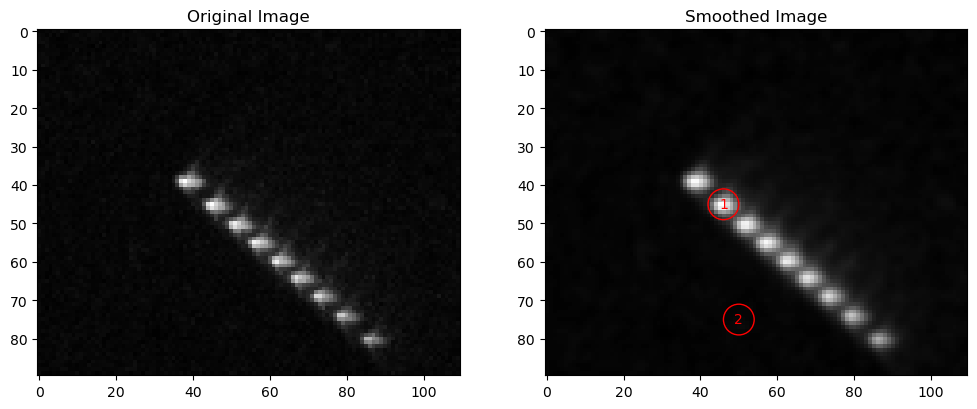

Counts in original image: [3788    0]


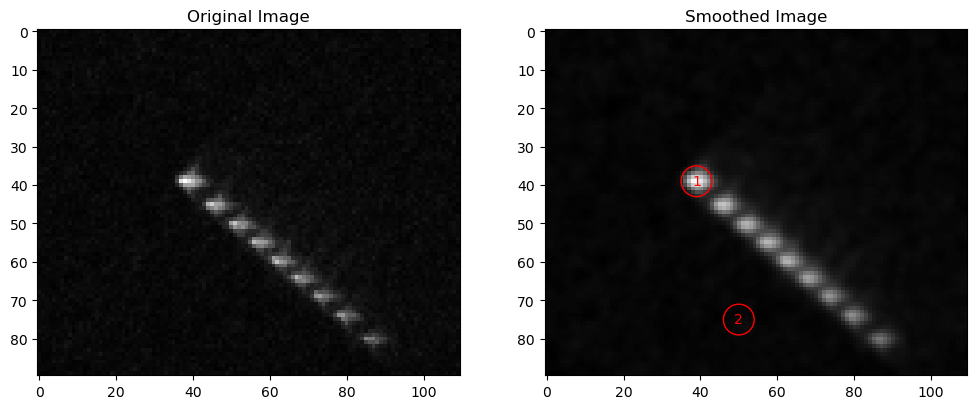

Counts in original image: [3120    0]


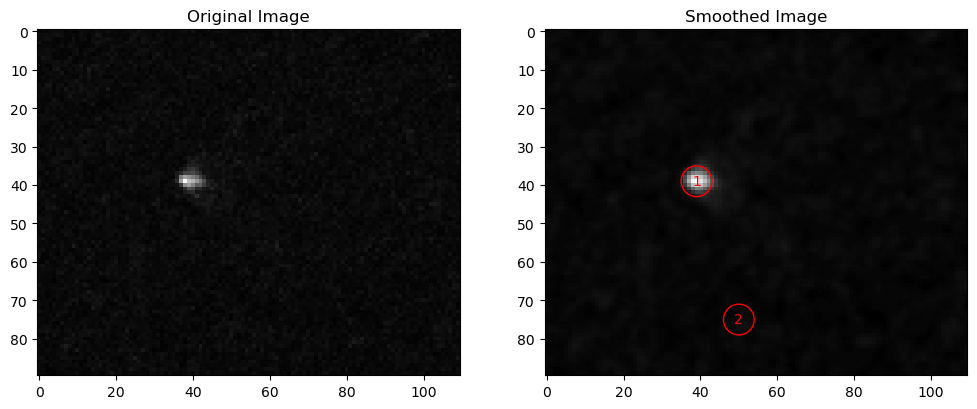

Counts in original image: [2654    0]


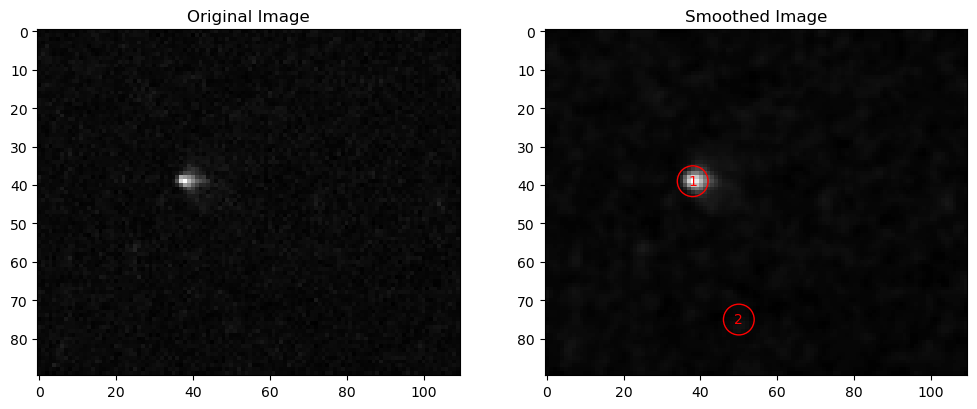

Counts in original image: [3154    0]


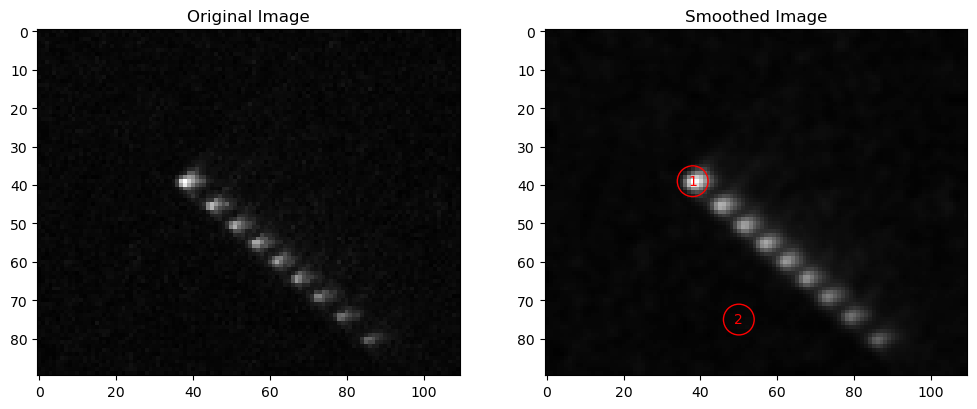

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage as ndimage
from skimage.feature import peak_local_max

num_peaks = 10
# Load the FITS file
fits_file_paths_1_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '15dB/' + 'nc-image_7.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '18dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '21dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '24dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '27dB/' + 'nc-image_4.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '30dB/' + 'nc-image_3.fits']
fits_file_paths_1_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '15dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '18dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '21dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '24dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '27dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_1/' + '30dB/' + 'nc-image_6.fits']

fits_file_paths_2_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '15dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '18dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '21dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '24dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '27dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '30dB/' + 'nc-image_1.fits']
fits_file_paths_2_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '15dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '18dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '21dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '24dB/' + 'nc-image_2.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '27dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_2/' + '30dB/' + 'nc-image_3.fits']

fits_file_paths_3_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '15dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '18dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '21dB/' + 'nc-image_4.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '24dB/' + 'nc-image_5.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '27dB/' + 'nc-image_5.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '30dB/' + 'nc-image_1.fits']
fits_file_paths_3_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '15dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '18dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '21dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '24dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '27dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_3/' + '30dB/' + 'nc-image_4.fits']

fits_file_paths_4_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '15dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '18dB/' + 'nc-image_4.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '21dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '24dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '27dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '30dB/' + 'nc-image_7.fits']
fits_file_paths_4_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '15dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '18dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '21dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '24dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '27dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_4/' + '30dB/' + 'nc-image_2.fits']

fits_file_paths_5_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '15dB/' + 'nc-image_5.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '18dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '21dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '24dB/' + 'nc-image_5.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '27dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '30dB/' + 'nc-image_3.fits']
fits_file_paths_5_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '15dB/' + 'nc-image_8.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '18dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '21dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '24dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '27dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '30dB/' + 'nc-image_1.fits']

fits_file_paths_6_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '15dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '18dB/' + 'nc-image_4.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '21dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '24dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '27dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '30dB/' + 'nc-image_3.fits']
fits_file_paths_6_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '15dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '18dB/' + 'nc-image_2.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '21dB/' + 'nc-image_2.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '24dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '27dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_6/' + '30dB/' + 'nc-image_1.fits']

fits_file_paths_7_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '15dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '18dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '21dB/' + 'nc-image_5.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '24dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '27dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '30dB/' + 'nc-image_4.fits']
fits_file_paths_7_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '15dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '18dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '21dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '24dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '27dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_7/' + '30dB/' + 'nc-image_3.fits']

fits_file_paths_8_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '15dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '18dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '21dB/' + 'nc-image_5.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '24dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '27dB/' + 'nc-image_4.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '30dB/' + 'nc-image_2.fits']
fits_file_paths_8_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '15dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '18dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '21dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '24dB/' + 'nc-image_2.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '27dB/' + 'nc-image_1.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_8/' + '30dB/' + 'nc-image_1.fits']

fits_file_paths_9_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '15dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '18dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '21dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '24dB/' + 'nc-image_3.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '27dB/' + 'nc-image_1.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '30dB/' + 'nc-image_4.fits']
fits_file_paths_9_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '15dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '18dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '21dB/' + 'nc-image_2.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '24dB/' + 'nc-image_5.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '27dB/' + 'nc-image_4.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_9/' + '30dB/' + 'nc-image_1.fits']

i = 9
fits_file_paths = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_{i}/' + '30dB/' + 'nc-image_1.fits',
                   'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_{i}/' + '30dB/' + 'nc-image_2.fits',
                   'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_{i}/' + '30dB/' + 'nc-image_3.fits',
                   'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_{i}/' + '30dB/' + 'nc-image_4.fits',
                   'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_{i}/' + '30dB/' + 'nc-image_5.fits']

def process_fits_images(fits_file_paths, num_peaks=9):
    for fits_file_path in fits_file_paths:
        with fits.open(fits_file_path) as hdul:
            ion_image_data = hdul[0].data
        contrast_adjusted_data = scale_image_data(ion_image_data)
        center_x, center_y = contrast_adjusted_data.shape[1] // 2, contrast_adjusted_data.shape[0] // 2
        start_x = center_x - 45
        end_x = center_x + 65
        start_y = center_y - 20
        end_y = center_y + 70
        zoomed_data_global = contrast_adjusted_data[start_y:end_y, start_x:end_x]
        new_filename = fits_file_path.replace('.fits', ' zoomed image.tiff')
        tiff.imwrite(new_filename, zoomed_data_global)
        r = 4
        smoothed_data = ndimage.gaussian_filter(zoomed_data_global, sigma=1)
        coordinates = peak_local_max(smoothed_data, min_distance=1, num_peaks=num_peaks)
        coordinates = np.append(coordinates, [[75, 50]], axis=0)
        # print("\n\ncoordinates:", coordinates, "\n\n")
        circle_radius = r
        sums_inside_circles = []
        for peak in coordinates:
            mask = np.zeros_like(zoomed_data_global, dtype=bool)
            y, x = np.ogrid[:zoomed_data_global.shape[0], :zoomed_data_global.shape[1]]
            mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= circle_radius**2
            sums_inside_circles.append(np.sum(zoomed_data_global[mask_area]))
        print("Counts in original image:", sums_inside_circles - sums_inside_circles[-1])
        sorted_peaks = sorted(zip(sums_inside_circles, coordinates), reverse=True)
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(zoomed_data_global, cmap='gray')
        ax[0].set_title('Original Image')
        ax[1].imshow(smoothed_data, cmap='gray')
        ax[1].set_title('Smoothed Image')
        for idx, (value, peak) in enumerate(sorted_peaks, start=1):
            circle = plt.Circle((peak[1], peak[0]), radius=r, color='red', fill=False)
            ax[1].add_patch(circle)
            ax[1].text(peak[1], peak[0], str(idx), color='red', ha='center', va='center')

        plt.show()

process_fits_images(fits_file_paths, num_peaks=1)


Counts in signal image: [   0.  358.  375.  678.  757. 2373. 3612. 3686. 3995. 4645.] 



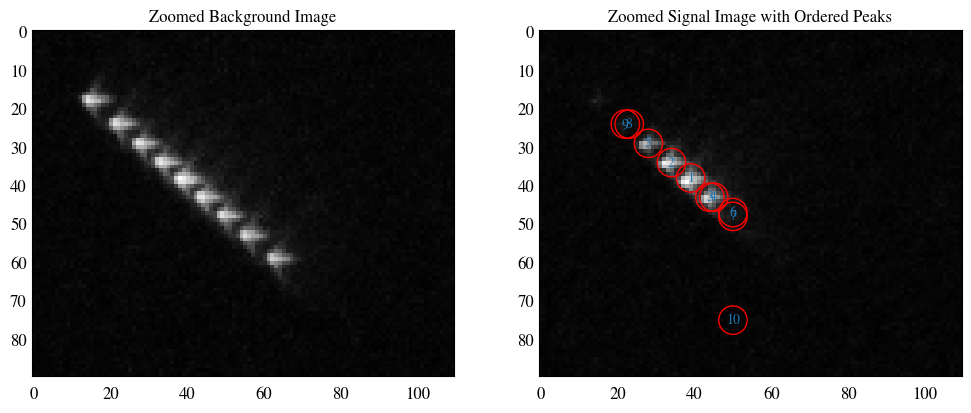


Counts in signal image: [   0.    6.   50.   69.  183. 1021. 1370. 3886. 4064. 4809.] 



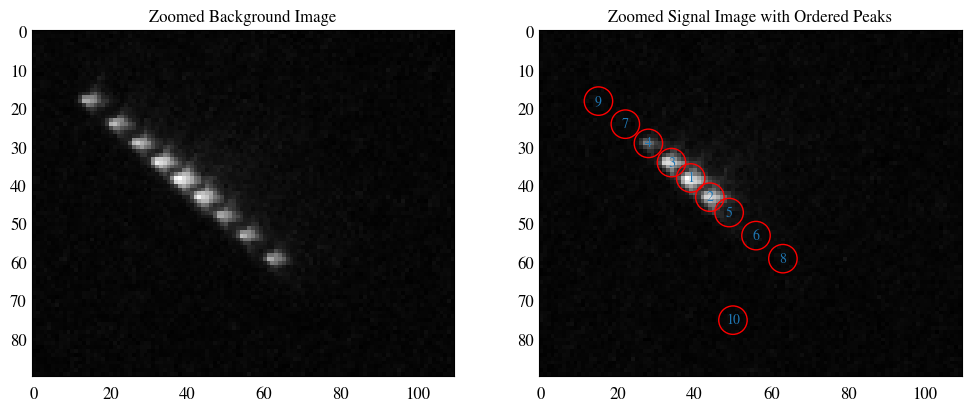


Counts in signal image: [   0.  429.  462.  527. 2834. 3060. 3142. 3329. 3539. 4702.] 



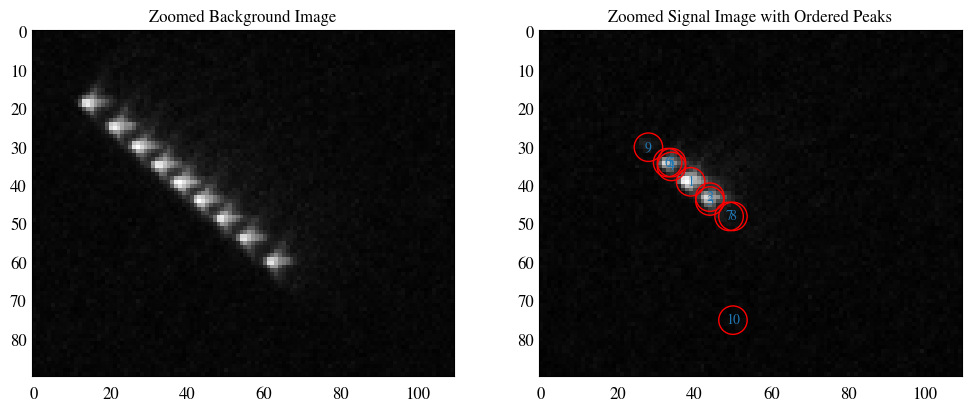


Counts in signal image: [   0.   22.   38.   68.   99.  201.  238. 1753. 1982. 3900.] 



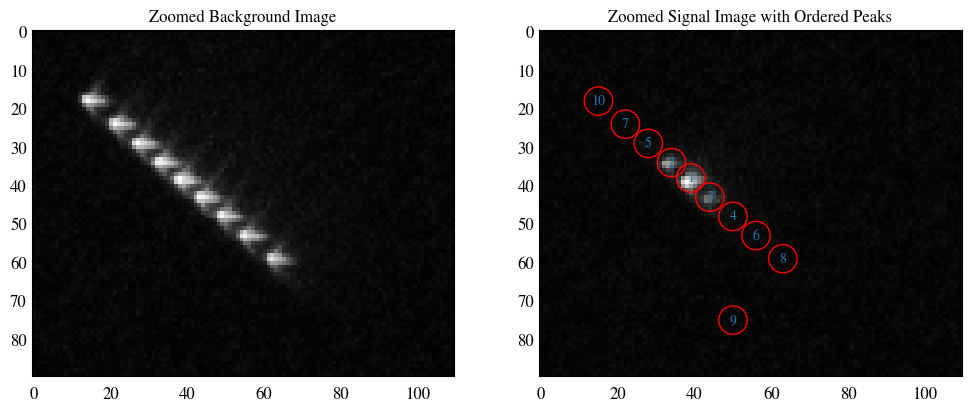


Counts in signal image: [   0.   22.   30.   49.  106.  143.  650.  975. 3667. 3693.] 



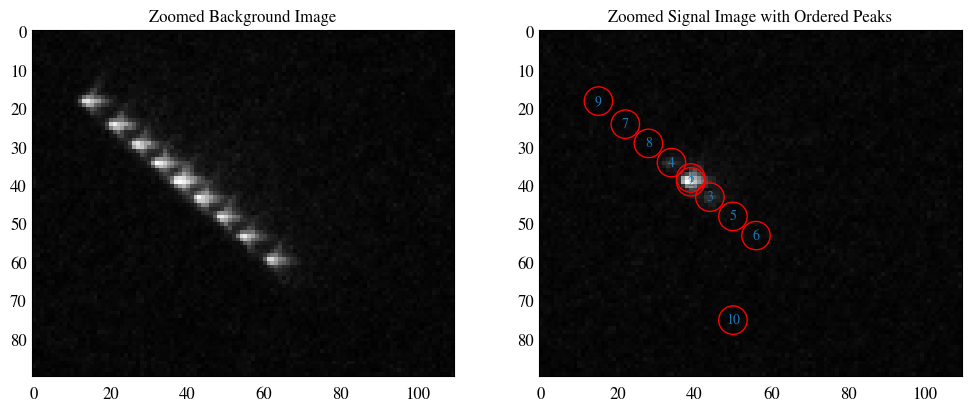


Counts in signal image: [   0.   40.   68.   68.  116.  116.  171.  408.  671. 2682.] 



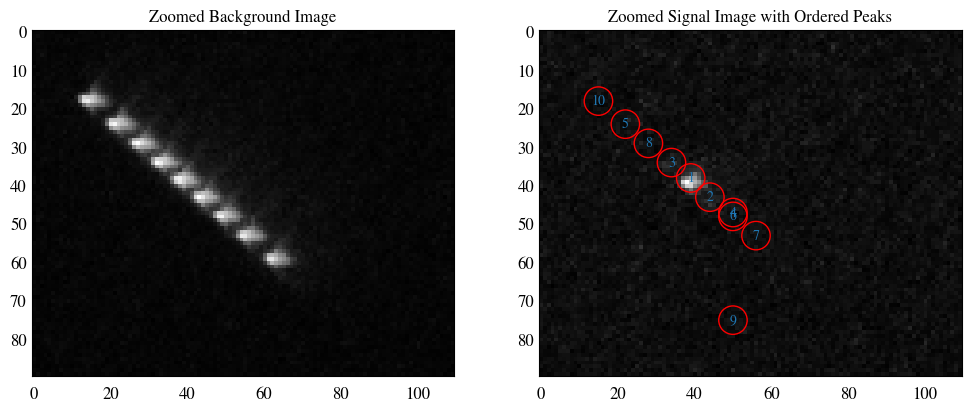

In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage as ndimage
from skimage.feature import peak_local_max

def scale_image_data(image_data, scale_min=None, scale_max=None):
    """Scale the image data between 0 and 1 using min-max scaling."""
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

def process_fits_images(fits_file_paths_signal, fits_file_paths_bg, num_peaks=9):
    for signal_path, bg_path in zip(fits_file_paths_signal, fits_file_paths_bg):
        with fits.open(bg_path) as hdul:
            bg_image_data = hdul[0].data
        bg_contrast_data = scale_image_data(bg_image_data)

        with fits.open(signal_path) as hdul:
            signal_image_data = hdul[0].data
        signal_contrast_data = scale_image_data(signal_image_data)

        center_x, center_y = signal_contrast_data.shape[1] // 2, signal_contrast_data.shape[0] // 2
        start_x = center_x - 45
        end_x = center_x + 65
        start_y = center_y - 20
        end_y = center_y + 70

        zoomed_bg_data = bg_contrast_data[start_y:end_y, start_x:end_x]
        zoomed_signal_data = signal_contrast_data[start_y:end_y, start_x:end_x]

        bg_smoothed_data = ndimage.gaussian_filter(zoomed_bg_data, sigma=2)
        bg_coordinates = peak_local_max(bg_smoothed_data, min_distance=1, num_peaks=num_peaks)
        bg_coordinates = np.append(bg_coordinates, [[75, 50]], axis=0)

        r = 3.7
        sums_inside_circles = []
        for peak in bg_coordinates:
            mask = np.zeros_like(zoomed_signal_data, dtype=bool)
            y, x = np.ogrid[:zoomed_signal_data.shape[0], :zoomed_signal_data.shape[1]]
            mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= r**2
            sums_inside_circles.append(np.sum(zoomed_signal_data[mask_area].astype(np.float64)))

        sorted_indices = np.argsort(sums_inside_circles)[::-1]
        sorted_peaks = bg_coordinates[sorted_indices]
        sums_inside_circles = sorted(sums_inside_circles)
        print("\nCounts in signal image:", sums_inside_circles - sums_inside_circles[0], "\n")

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(zoomed_bg_data, cmap='gray')
        ax[0].set_title('Zoomed Background Image')
        ax[1].imshow(zoomed_signal_data, cmap='gray')
        ax[1].set_title('Zoomed Signal Image with Ordered Peaks')

        for idx, peak in enumerate(sorted_peaks, start=1):
            circle = plt.Circle((peak[1], peak[0]), radius=r, color='red', fill=False)
            ax[1].add_patch(circle)
            ax[1].text(peak[1], peak[0], str(idx), color='C0', ha='center', va='center')

        plt.show()

# Example usage
process_fits_images(fits_file_paths_5_signal, fits_file_paths_5_bg, num_peaks=9)


Counts in signal image: [   0.   30.   74.   93.  207. 1045. 1394. 3910. 4088. 4833.] 



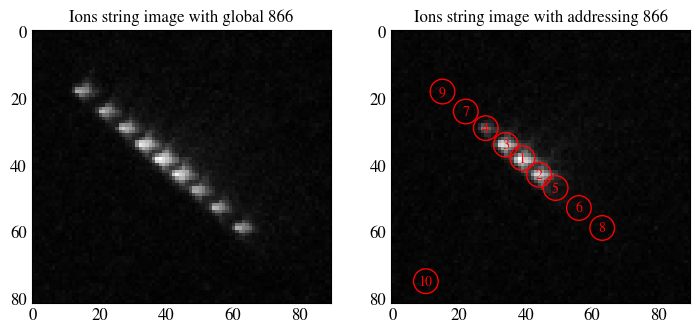

In [ ]:
from scipy.signal import find_peaks
import matplotlib
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": False
    }
)

fits_file_paths_5_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '18dB/' + 'nc-image_2.fits',
                            'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '24dB/' + 'nc-image_5.fits']
fits_file_paths_5_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '18dB/' + 'nc-image_3.fits',
                        'D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '24dB/' + 'nc-image_4.fits']

fits_file_paths_5_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '24dB/' + 'nc-image_5.fits']
fits_file_paths_5_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '24dB/' + 'nc-image_4.fits']

fits_file_paths_5_signal = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '18dB/' + 'nc-image_2.fits']
fits_file_paths_5_bg = ['D:/Google_Drive/NUVU_Data/NuPixel Images/' + f'Crosstalk_ion_5/' + '18dB/' + 'nc-image_3.fits']

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage as ndimage
from skimage.feature import peak_local_max

def scale_image_data(image_data, scale_min=None, scale_max=None):
    """Scale the image data between 0 and 1 using min-max scaling."""
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

def process_fits_images(fits_file_paths_signal, fits_file_paths_bg, num_peaks=9):
    for signal_path, bg_path in zip(fits_file_paths_signal, fits_file_paths_bg):
        with fits.open(bg_path) as hdul:
            bg_image_data = hdul[0].data
        bg_contrast_data = scale_image_data(bg_image_data)

        with fits.open(signal_path) as hdul:
            signal_image_data = hdul[0].data
        signal_contrast_data = scale_image_data(signal_image_data)

        center_x, center_y = signal_contrast_data.shape[1] // 2, signal_contrast_data.shape[0] // 2
        start_x = center_x - 45
        end_x = center_x + 45
        start_y = center_y - 20
        end_y = center_y + 62

        zoomed_bg_data = bg_contrast_data[start_y:end_y, start_x:end_x]
        zoomed_signal_data = signal_contrast_data[start_y:end_y, start_x:end_x]

        bg_smoothed_data = ndimage.gaussian_filter(zoomed_bg_data, sigma=2)
        bg_coordinates = peak_local_max(bg_smoothed_data, min_distance=1, num_peaks=num_peaks)
        bg_coordinates = np.append(bg_coordinates, [[75, 10]], axis=0)

        r = 3.7
        sums_inside_circles = []
        for peak in bg_coordinates:
            mask = np.zeros_like(zoomed_signal_data, dtype=bool)
            y, x = np.ogrid[:zoomed_signal_data.shape[0], :zoomed_signal_data.shape[1]]
            mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= r**2
            sums_inside_circles.append(np.sum(zoomed_signal_data[mask_area].astype(np.float64)))

        sorted_indices = np.argsort(sums_inside_circles)[::-1]
        sorted_peaks = bg_coordinates[sorted_indices]
        sums_inside_circles = sorted(sums_inside_circles)
        print("\nCounts in signal image:", sums_inside_circles - sums_inside_circles[0], "\n")

        half_column_width_inches = 4.25 * 2
        aspect_ratio = 2  # You can adjust this for your desired aspect ratio

        fig, ax = plt.subplots(1, 2, figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
        ax[0].imshow(zoomed_bg_data, cmap='gray')
        ax[0].set_title('Ions string image with global 866', fontdict={'family': 'STIXGeneral', 'size': 12})
        ax[1].imshow(zoomed_signal_data, cmap='gray')
        ax[1].set_title('Ions string image with addressing 866', fontdict={'family': 'STIXGeneral', 'size': 12})

        for idx, peak in enumerate(sorted_peaks, start=1):
            circle = plt.Circle((peak[1], peak[0]), radius=r, color='red', fill=False)
            ax[1].add_patch(circle)
            ax[1].text(peak[1], peak[0], str(idx), color='red', ha='center', va='center')

        pdf_filename = 'Ion_string_image_18dB.pdf'
        plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

        plt.show()

# Example usage
process_fits_images(fits_file_paths_5_signal, fits_file_paths_5_bg, num_peaks=9)

[[39 39]
 [45 46]
 [48 68]
 [48 69]
 [49 70]
 [50 52]
 [55 57]
 [59 63]
 [59 62]
 [60 63]
 [64 68]
 [68 73]
 [74 79]
 [75 50]
 [80 87]
 [80 86]]

Counts in signal image: [4534. 2030.   68.   51.   31.  646.  402.  167.  217.  146.  164.   64.
    0.   65.   18.   39.] 



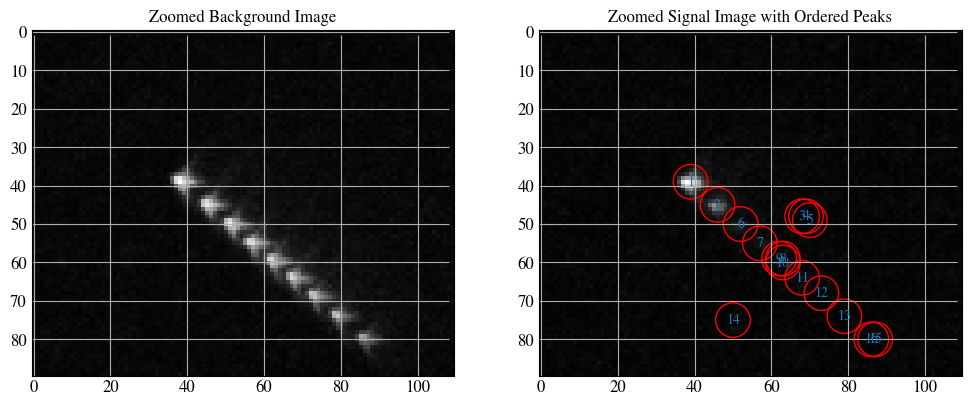

[[34 55]
 [39 39]
 [45 46]
 [50 52]
 [52 74]
 [55 57]
 [59 63]
 [60 63]
 [60 84]
 [64 68]
 [65 86]
 [69 74]
 [74 80]
 [74 79]
 [75 50]
 [80 87]]

Counts in signal image: [2.620e+02 4.421e+03 1.450e+03 4.260e+02 1.700e+01 2.360e+02 1.480e+02
 1.270e+02 4.300e+01 1.180e+02 2.700e+01 8.000e+00 0.000e+00 2.000e+00
 7.700e+01 7.000e+00] 



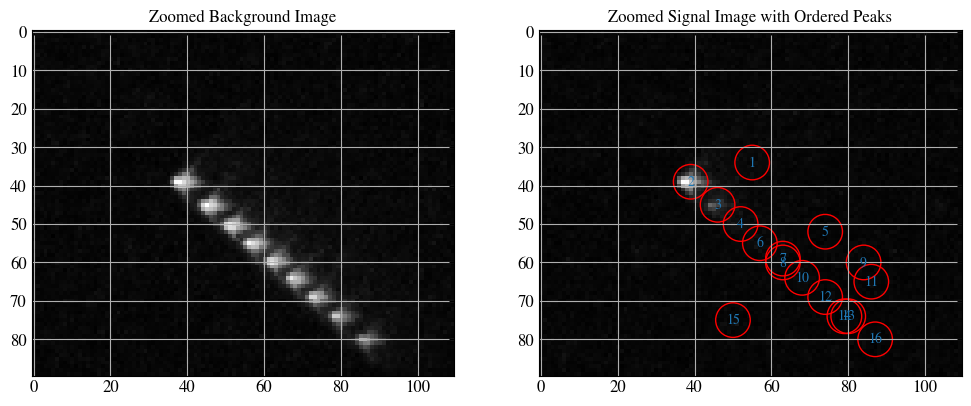

[[34 53]
 [34 54]
 [36 53]
 [39 39]
 [45 46]
 [50 52]
 [55 58]
 [59 63]
 [64 68]
 [68 74]
 [68 73]
 [69 74]
 [74 80]
 [75 50]
 [80 87]
 [80 86]]

Counts in signal image: [ 267.  259.  281. 4514.  868.  299.  191.  110.  103.   44.   49.   42.
    0.   90.   12.   32.] 



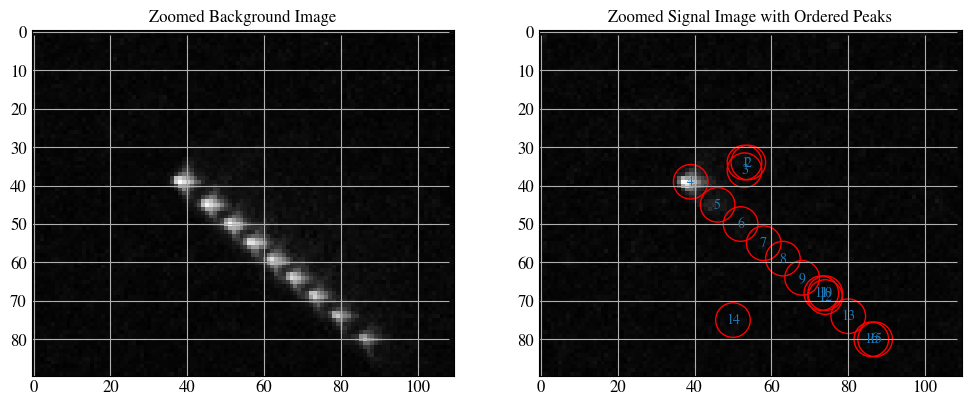

[[39 39]
 [45 46]
 [49 72]
 [50 52]
 [54 57]
 [55 57]
 [55 58]
 [59 63]
 [64 68]
 [68 73]
 [73 79]
 [74 79]
 [74 80]
 [75 50]
 [80 86]
 [80 87]]

Counts in signal image: [4027.  627.  107.  248.  199.  189.  212.  141.   85.   23.   25.   36.
   31.  110.   22.    0.] 



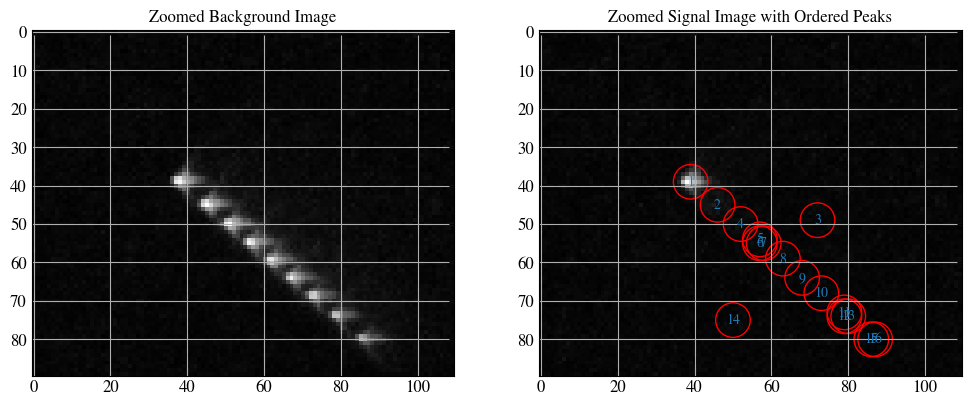

[[39 39]
 [45 46]
 [46 72]
 [46 71]
 [50 52]
 [55 57]
 [55 58]
 [59 63]
 [60 63]
 [64 68]
 [69 74]
 [74 80]
 [74 79]
 [75 50]
 [80 86]
 [80 87]]

Counts in signal image: [4527.  675.  138.  148.  297.  198.  194.  117.  122.  118.   45.   69.
   57.  118.   32.    0.] 



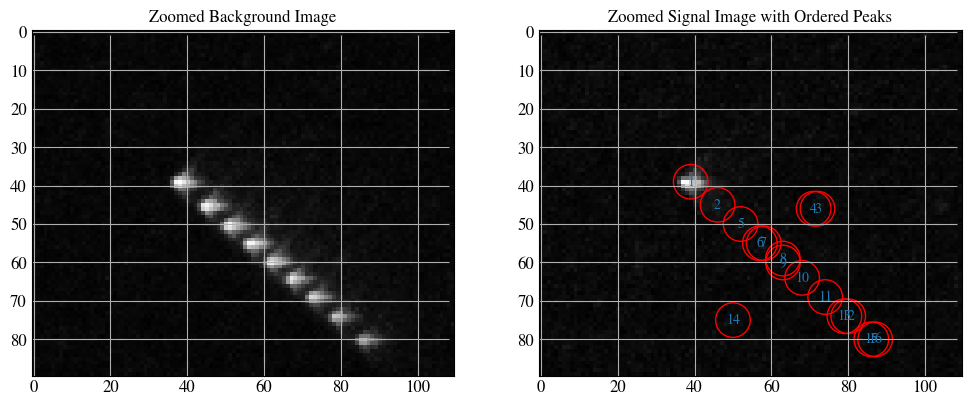

[[39 39]
 [45 46]
 [47 67]
 [48 70]
 [49 71]
 [50 52]
 [55 58]
 [55 57]
 [60 63]
 [64 68]
 [69 74]
 [74 80]
 [74 79]
 [75 50]
 [80 87]
 [80 86]]

Counts in signal image: [3273.  454.   20.   96.   98.  188.  125.  104.  168.   66.   29.   27.
   24.  125.    0.   29.] 



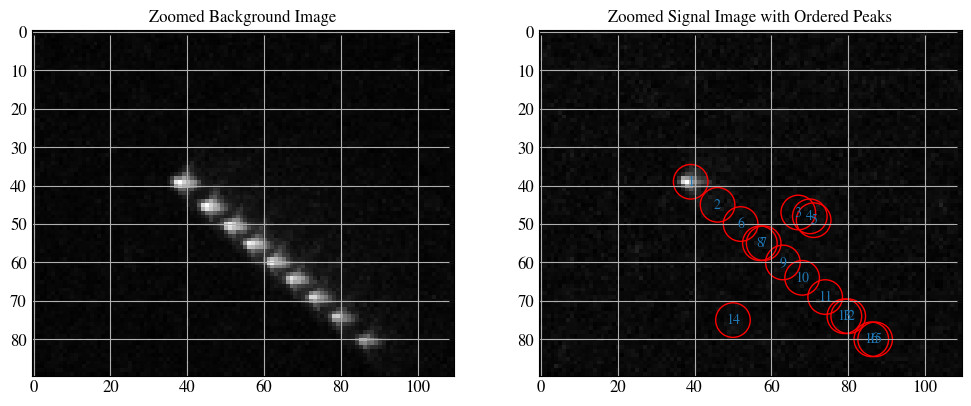

In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage as ndimage
from skimage.feature import peak_local_max

def scale_image_data(image_data, scale_min=None, scale_max=None):
    """Scale the image data between 0 and 1 using min-max scaling."""
    if scale_min is None:
        scale_min = np.min(image_data)
    if scale_max is None:
        scale_max = np.max(image_data)
    scaled_data = (image_data - scale_min) / (scale_max - scale_min)
    scaled_data[scaled_data < 0] = 0
    scaled_data[scaled_data > 1] = 1
    return (scaled_data * 255).astype(np.uint8)

def process_fits_images(fits_file_paths_signal, fits_file_paths_bg, num_peaks=9):
    for signal_path, bg_path in zip(fits_file_paths_signal, fits_file_paths_bg):
        with fits.open(bg_path) as hdul:
            bg_image_data = hdul[0].data
        bg_contrast_data = scale_image_data(bg_image_data)

        with fits.open(signal_path) as hdul:
            signal_image_data = hdul[0].data
        signal_contrast_data = scale_image_data(signal_image_data)

        center_x, center_y = signal_contrast_data.shape[1] // 2, signal_contrast_data.shape[0] // 2
        start_x = center_x - 45
        end_x = center_x + 65
        start_y = center_y - 20
        end_y = center_y + 70

        zoomed_bg_data = bg_contrast_data[start_y:end_y, start_x:end_x]
        zoomed_signal_data = signal_contrast_data[start_y:end_y, start_x:end_x]

        bg_smoothed_data = ndimage.gaussian_filter(zoomed_bg_data, sigma=2)
        bg_coordinates = peak_local_max(bg_smoothed_data, min_distance=1, num_peaks=num_peaks)
        bg_coordinates = np.append(bg_coordinates, [[75, 50]], axis=0)

        r = 4.5
        sums_inside_circles = []
        for peak in bg_coordinates:
            mask = np.zeros_like(zoomed_signal_data, dtype=bool)
            y, x = np.ogrid[:zoomed_signal_data.shape[0], :zoomed_signal_data.shape[1]]
            mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= r**2
            sums_inside_circles.append(np.sum(zoomed_signal_data[mask_area].astype(np.float64)))

        sorted_indices = np.argsort(bg_coordinates[:, 0])
        sorted_peaks = bg_coordinates[sorted_indices]
        sums_inside_circles = []
        print(sorted_peaks)
        for peak in sorted_peaks:
            mask = np.zeros_like(zoomed_signal_data, dtype=bool)
            y, x = np.ogrid[:zoomed_signal_data.shape[0], :zoomed_signal_data.shape[1]]
            mask_area = (x - peak[1])**2 + (y - peak[0])**2 <= r**2
            sums_inside_circles.append(np.sum(zoomed_signal_data[mask_area].astype(np.float64)))
        print("\nCounts in signal image:", sums_inside_circles - np.min(sums_inside_circles), "\n")

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(zoomed_bg_data, cmap='gray')
        ax[0].set_title('Zoomed Background Image')
        ax[1].imshow(zoomed_signal_data, cmap='gray')
        ax[1].set_title('Zoomed Signal Image with Ordered Peaks')

        for idx, peak in enumerate(sorted_peaks, start=1):
            circle = plt.Circle((peak[1], peak[0]), radius=r, color='red', fill=False)
            ax[1].add_patch(circle)
            ax[1].text(peak[1], peak[0], str(idx), color='C0', ha='center', va='center')

        plt.show()

# Example usage
process_fits_images(fits_file_paths_9_signal, fits_file_paths_9_bg, num_peaks=15)

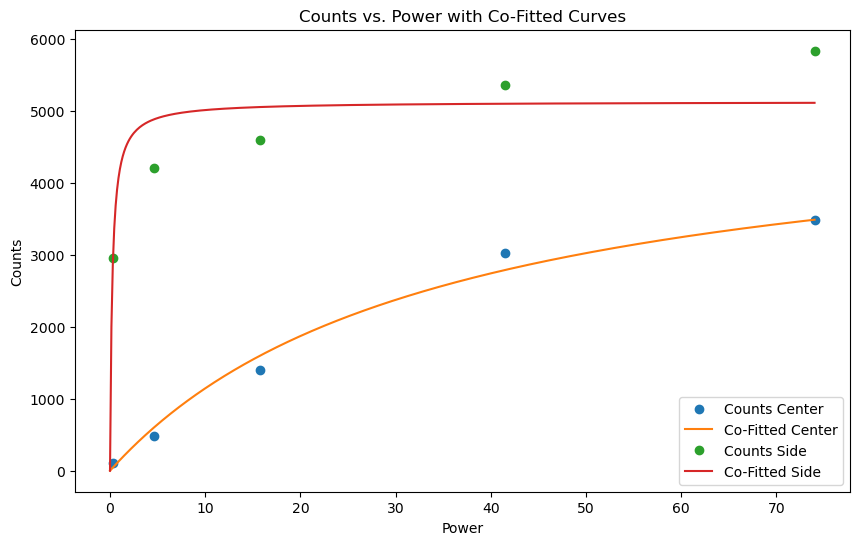

0.0066725474284591


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data initialization
power = np.array([0.283, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([107, 481, 1402, 3023, 3479])
counts_side = np.array([2953, 4208, 4599, 5360, 5838])

# Define the fitting function
def fit_function(power, a, b):
    return (b * power) / (a + power)

# Combined fitting function for both datasets
def combined_fit_function_combined_params(power, a1, b, a2):
    midpoint = len(power) // 2
    power_center, power_side = power[:midpoint], power[midpoint:]
    counts_center_fit = (b * power_center) / (a1 + power_center)
    counts_side_fit = (b * power_side) / (a2 + power_side)
    return np.concatenate([counts_center_fit, counts_side_fit])

# Combining both datasets for the fitting process
combined_power = np.concatenate([power, power])
combined_counts = np.concatenate([counts_center, counts_side])

# Co-fitting with constraints that a1, a2, and b must be larger than 0
initial_guess = [1, 1, 1]  # Initial guess for a1, b, a2
bounds = (0, np.inf)       # Bounds for a1, b, a2
params_combined, _ = curve_fit(combined_fit_function_combined_params, combined_power, combined_counts, 
                               p0=initial_guess, bounds=bounds)

# Extracting fitted parameters
a1_fitted, b_fitted, a2_fitted = params_combined

# Generating a range of power values for a smoother curve
power_fine = np.linspace(0, power.max(), 500)

# Calculating fitted data for the finer range of power values
fitted_center_fine_combined = fit_function(power_fine, a1_fitted, b_fitted)
fitted_side_fine_combined = fit_function(power_fine, a2_fitted, b_fitted)

# Plotting the data and the co-fitted curves
plt.figure(figsize=(10, 6))
plt.plot(power, counts_center, 'o', label='Counts Center')
plt.plot(power_fine, fitted_center_fine_combined, label='Co-Fitted Center')
plt.plot(power, counts_side, 'o', label='Counts Side')
plt.plot(power_fine, fitted_side_fine_combined, label='Co-Fitted Side')
plt.xlabel('Power')
plt.ylabel('Counts')
plt.title('Counts vs. Power with Co-Fitted Curves')
plt.legend()
plt.show()

print(a2_fitted / a1_fitted)

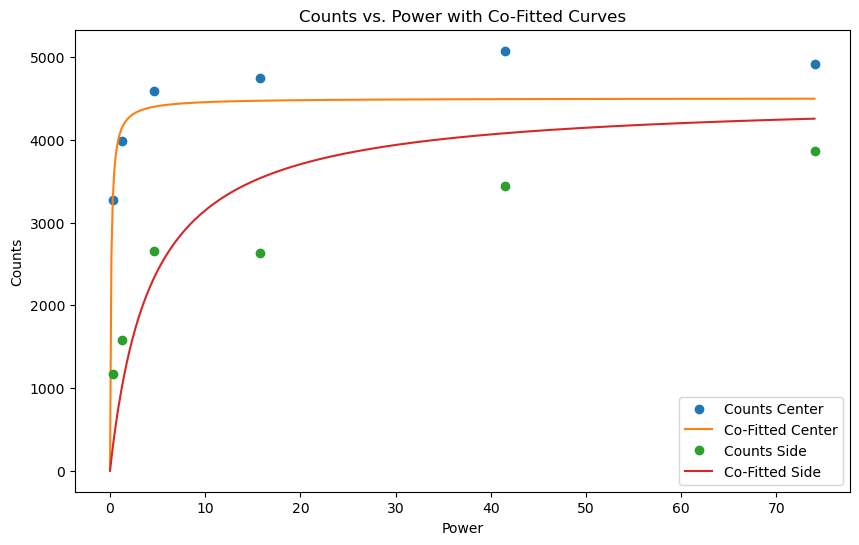

0.025280637533905533


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
# counts_center = np.array()
# counts_side_1 = np.array()
# counts_side_2 = np.array()
# counts_side_3 = np.array()
# counts_side_4 = np.array()
# counts_side_5 = np.array()
# counts_side_6 = np.array()
# counts_side_7 = np.array()
# counts_side_8 = np.array()

# Data initialization
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2996, 4175, 4178, 4657, 5360, 5838])
counts_side_1 = np.array([117, 815, 506, 1448.5, 3023, 3479])
counts_side_2 = np.array([68, 93, 115, 305, 650, 612])
counts_side_3 = np.array([236, 41.3, 115, 154.5, 107, 285])
counts_side_4 = np.array([72, 68, 25, 58, 18, 91])
counts_side_5 = np.array([81, 130, 136, 162, 74, 177])
counts_side_6 = np.array([64, 86, 103, 127, 70, 68])
counts_side_7 = np.array([86.5, 1, 66, 91, 5, 50])
counts_side_8 = np.array([0, 4, 0, 0, 24, 9])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2953, 3561, 2894, 3105, 3068.5, 3342])
counts_side_1 = np.array([334, 278, 615.5, 434, 1107, 1437])
counts_side_2 = np.array([258, 608, 919, 1583, 2043, 2213.5])
counts_side_3 = np.array([22, 89, 257, 428, 435, 806])
counts_side_4 = np.array([104, 31, 187, 159, 101.667, 130.5])
counts_side_5 = np.array([25, 9, 96, 104, 88, 166])
counts_side_6 = np.array([112, 52, 148, 77.5, 41, 22])
counts_side_7 = np.array([131, 0, 124, 94, 51, 78])
counts_side_8 = np.array([43, 22, 84, 32, 0, 5])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3431, 4166, 4299.5, 4970.5, 4945, 5480.5])
counts_side_1 = np.array([74.5, 226, 198, 230, 323, 627])
counts_side_2 = np.array([704, 787, 679, 1366, 1375.5, 1921])
counts_side_3 = np.array([548, 1265, 1938, 3448, 4001, 4538])
counts_side_4 = np.array([78, 123, 169, 564, 1326, 2264])
counts_side_5 = np.array([223, 105, 134, 184, 227.5, 528])
counts_side_6 = np.array([39, 6.67, 0, 44, 0, 60])
counts_side_7 = np.array([203, 108, 98, 74, 132.5, 207])
counts_side_8 = np.array([159, 151, 80, 50, 36, 77.5])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3662, 4086, 4383, 5629, 5866, 5231])
counts_side_1 = np.array([130, 103.5, 103, 213, 344, 380])
counts_side_2 = np.array([135, 262, 363, 633.5, 958, 740.5])
counts_side_3 = np.array([1105, 1589, 1840.5, 3314, 4537, 3751])
counts_side_4 = np.array([304, 1117, 2521, 3634, 4257, 4390])
counts_side_5 = np.array([98, 69, 189, 767, 1519.5, 2190])
counts_side_6 = np.array([174, 111, 97, 140, 220, 352])
counts_side_7 = np.array([0, 18.5, 6, 92, 172, 390])
counts_side_8 = np.array([81, 73, 60.5, 79, 90, 134])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3067, 4147.5, 4551, 5607, 6099, 5776])
counts_side_1 = np.array([97, 16, 43, 2, 82, 177])
counts_side_2 = np.array([88, 121, 155, 241, 305, 411])
counts_side_3 = np.array([189.5, 215, 398, 820.5, 1866, 1151.5])
counts_side_4 = np.array([1018, 1494, 2402, 4245.5, 5288, 4594.5])
counts_side_5 = np.array([504, 795, 2328, 3624, 4625, 4819])
counts_side_6 = np.array([76, 25, 248, 551, 1575, 2677])
counts_side_7 = np.array([167, 40, 84, 67, 129, 442])
counts_side_8 = np.array([0, 0, 0, 12, 7, 310])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3272, 3983, 4586, 4744, 5078, 4916])
counts_side_1 = np.array([79, 0, 27, 46, 16, 44])
counts_side_2 = np.array([48, 102, 76, 98, 35, 134])
counts_side_3 = np.array([143, 107, 177, 210, 158, 267])
counts_side_4 = np.array([245, 276, 511, 795, 754, 815])
counts_side_5 = np.array([1164, 1585, 2652.5, 2633, 3442, 3871])
counts_side_6 = np.array([394, 754, 2654, 2848, 3365, 3457])
counts_side_7 = np.array([39, 85, 222, 317, 740, 1235])
counts_side_8 = np.array([5, 124, 112, 109, 155, 343])

counts_side = counts_side_5

# Define the fitting function
def fit_function(power, a, b):
    return (b * power) / (a + power)

# Combined fitting function for both datasets
def combined_fit_function_combined_params(power, a1, b, a2):
    midpoint = len(power) // 2
    power_center, power_side = power[:midpoint], power[midpoint:]
    counts_center_fit = (b * power_center) / (a1 + power_center) #+ c
    counts_side_fit = (b * power_side) / (a2 + power_side) #+ c
    return np.concatenate([counts_center_fit, counts_side_fit])

# Combining both datasets for the fitting process
combined_power = np.concatenate([power, power])
combined_counts = np.concatenate([counts_center, counts_side])

# Co-fitting with constraints that a1, a2, and b must be larger than 0
initial_guess = [1, 1, 1]  # Initial guess for a1, b, a2
bounds = (0, np.inf)       # Bounds for a1, b, a2
params_combined, _ = curve_fit(combined_fit_function_combined_params, combined_power, combined_counts, 
                               p0=initial_guess, bounds=bounds)

# Extracting fitted parameters
a1_fitted, b_fitted, a2_fitted = params_combined

# Generating a range of power values for a smoother curve
power_fine = np.linspace(0, power.max(), 500)

# Calculating fitted data for the finer range of power values
fitted_center_fine_combined = fit_function(power_fine, a1_fitted, b_fitted)#, c_fitted)
fitted_side_fine_combined = fit_function(power_fine, a2_fitted, b_fitted)#, c_fitted)

# Plotting the data and the co-fitted curves
plt.figure(figsize=(10, 6))
plt.plot(power, counts_center, 'o', label='Counts Center')
plt.plot(power_fine, fitted_center_fine_combined, label='Co-Fitted Center')
plt.plot(power, counts_side, 'o', label='Counts Side')
plt.plot(power_fine, fitted_side_fine_combined, label='Co-Fitted Side')
plt.xlabel('Power')
plt.ylabel('Counts')
plt.title('Counts vs. Power with Co-Fitted Curves')
plt.legend()
plt.show()

print(a1_fitted / a2_fitted)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
# counts_center = np.array()
# counts_side_1 = np.array()
# counts_side_2 = np.array()
# counts_side_3 = np.array()
# counts_side_4 = np.array()
# counts_side_5 = np.array()
# counts_side_6 = np.array()
# counts_side_7 = np.array()
# counts_side_8 = np.array()

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5])
counts_center = np.array([3067, 4147.5, 4551, 5607, 6099])
counts_side_1 = np.array([97, 16, 43, 2, 82])
counts_side_2 = np.array([88, 121, 155, 241, 305])
counts_side_3 = np.array([189.5, 215, 398, 820.5, 1866])
counts_side_4 = np.array([1018, 1494, 2402, 4245.5, 5288])
counts_side_5 = np.array([504, 795, 2328, 3624, 4625])
counts_side_6 = np.array([76, 25, 248, 551, 1575])
counts_side_7 = np.array([167, 40, 84, 67, 129])
counts_side_8 = np.array([0, 0, 0, 12, 7])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3272, 3983, 4586, 4744, 5078, 4916])
counts_side_1 = np.array([79, 0, 27, 46, 16, 44])
counts_side_2 = np.array([48, 102, 76, 98, 35, 134])
counts_side_3 = np.array([143, 107, 177, 210, 158, 267])
counts_side_4 = np.array([245, 276, 511, 795, 754, 815])
counts_side_5 = np.array([1164, 1585, 2652.5, 2633, 3442, 3871])
counts_side_6 = np.array([394, 754, 2654, 2848, 3365, 3457])
counts_side_7 = np.array([39, 85, 222, 317, 740, 1235])
counts_side_8 = np.array([5, 124, 112, 109, 155, 343])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2491, 4181, 4984, 4170, 5040, 5429])
counts_side_1 = np.array([0, 0, 7.5, 9.33, 1, 0])
counts_side_2 = np.array([14, 85, 102, 88, 90.5, 94])
counts_side_3 = np.array([121, 125, 202.5, 107, 194, 255])
counts_side_4 = np.array([41, 109, 231, 238, 325.5, 438.5])
counts_side_5 = np.array([157.5, 348, 583, 481, 890, 1552])
counts_side_6 = np.array([755, 1730, 2743, 2052, 3302, 4517])
counts_side_7 = np.array([206, 771, 1428, 2251, 3971, 4276])
counts_side_8 = np.array([96, 67, 177, 358, 997, 1828])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3420, 4438, 4564, 4712, 5095, 4756])
counts_side_1 = np.array([0, 3, 0, 33, 14, 0])
counts_side_2 = np.array([56, 0, 79, 21, 5.5, 62])
counts_side_3 = np.array([85, 84, 90, 52, 68, 181])
counts_side_4 = np.array([139.667, 131.5, 135, 109, 194, 248])
counts_side_5 = np.array([134, 142, 165, 216, 247, 268])
counts_side_6 = np.array([201, 277, 381, 432, 801.5, 1092])
counts_side_7 = np.array([526, 831, 1410, 1501, 2765, 3011])
counts_side_8 = np.array([205.5, 426, 1425, 2570, 3628, 3472])

power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3273, 4527, 4005, 4514, 4421, 4534])
counts_side_1 = np.array([14.5, 16, 0, 22, 7, 28.5])
counts_side_2 = np.array([25.7, 63, 8.66667, 90, 1, 0])
counts_side_3 = np.array([29, 45, 1, 45, 8, 64])
counts_side_4 = np.array([66, 118, 63, 103, 118, 164])
counts_side_5 = np.array([168, 119.5, 119, 110, 137.5, 176.667])
counts_side_6 = np.array([114.5, 196, 178, 191, 236, 402])
counts_side_7 = np.array([188, 297, 226, 299, 426, 646])
counts_side_8 = np.array([454, 675, 605, 868, 1450, 2030])

# First ion
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2996, 4175, 4178, 4657, 5360, 5838])
counts_side_1 = np.array([117, 815, 506, 1448.5, 3023, 3479])
counts_side_2 = np.array([68, 93, 115, 305, 650, 612])
counts_side_3 = np.array([236, 41.3, 115, 154.5, 107, 285])
counts_side_4 = np.array([72, 68, 25, 58, 18, 91])
counts_side_5 = np.array([81, 130, 136, 162, 74, 177])
counts_side_6 = np.array([64, 86, 103, 127, 70, 68])
counts_side_7 = np.array([86.5, 1, 66, 91, 5, 50])
counts_side_8 = np.array([0, 4, 0, 0, 24, 9])

# # Second ion
# power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
# counts_center = np.array([2953, 3561, 2894, 3105, 3068.5, 3342])
# counts_side_1 = np.array([334, 278, 615.5, 434, 1107, 1437])
# counts_side_2 = np.array([258, 608, 919, 1583, 2043, 2213.5])
# counts_side_3 = np.array([22, 89, 257, 428, 435, 806])
# counts_side_4 = np.array([104, 31, 187, 159, 101.667, 130.5])
# counts_side_5 = np.array([25, 9, 96, 104, 88, 166])
# counts_side_6 = np.array([112, 52, 148, 77.5, 41, 22])
# counts_side_7 = np.array([131, 0, 124, 94, 51, 78])
# counts_side_8 = np.array([43, 22, 84, 32, 0, 5])

# # Third ion
# power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
# counts_center = np.array([3431, 4166, 4299.5, 4970.5, 4945, 5480.5])
# counts_side_1 = np.array([74.5, 226, 198, 230, 323, 627])
# counts_side_2 = np.array([704, 787, 679, 1366, 1375.5, 1921])
# counts_side_3 = np.array([548, 1265, 1938, 3448, 4001, 4538])
# counts_side_4 = np.array([78, 123, 169, 564, 1326, 2264])
# counts_side_5 = np.array([223, 105, 134, 184, 227.5, 528])
# counts_side_6 = np.array([39, 6.67, 0, 44, 0, 60])
# counts_side_7 = np.array([203, 108, 98, 74, 132.5, 207])
# counts_side_8 = np.array([159, 151, 80, 50, 36, 77.5])

# # Fourth ion
# power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
# counts_center = np.array([3662, 4086, 4383, 5629, 5866, 5231])
# counts_side_1 = np.array([130, 103.5, 103, 213, 344, 380])
# counts_side_2 = np.array([135, 262, 363, 633.5, 958, 740.5])
# counts_side_3 = np.array([1105, 1589, 1840.5, 3314, 4537, 3751])
# counts_side_4 = np.array([304, 1117, 2521, 3634, 4257, 4390])
# counts_side_5 = np.array([98, 69, 189, 767, 1519.5, 2190])
# counts_side_6 = np.array([174, 111, 97, 140, 220, 352])
# counts_side_7 = np.array([0, 18.5, 6, 92, 172, 390])
# counts_side_8 = np.array([81, 73, 60.5, 79, 90, 134])

# power = np.array([0.283, 1.27, 4.67, 15.8, 41.5])
# counts_center = np.array([3067, 4147.5, 4551, 5607, 6099])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2996, 4175, 4178, 4657, 5360, 5838])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2491, 4181, 4984, 4170, 5040, 5429])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3272, 3983, 4586, 4744, 5078, 4916])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3420, 4438, 4564, 4712, 5095, 4756])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3273, 4527, 4005, 4514, 4421, 4534])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([2953, 3561, 2894, 3105, 3068.5, 3342])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3431, 4166, 4299.5, 4970.5, 4945, 5480.5])
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3662, 4086, 4383, 5629, 5866, 5231])
counts_side_1 = np.array([117, 815, 506, 1448.5, 3023, 3479])

counts_side = counts_side_1


# Data provided for counts_center across multiple measurements
counts_data = np.array([
    [2996, 4175, 4178, 4657, 5360, 5838],
    [2491, 4181, 4984, 4170, 5040, 5429],
    [3272, 3983, 4586, 4744, 5078, 4916],
    [3420, 4438, 4564, 4712, 5095, 4756],
    [3273, 4527, 4005, 4514, 4421, 4534],
    [2953, 3561, 2894, 3105, 3068.5, 3342],
    [3431, 4166, 4299.5, 4970.5, 4945, 5480.5],
    [3662, 4086, 4383, 5629, 5866, 5231]
])

# Calculating the average and standard deviation of counts_center across all measurements
average_counts = np.mean(counts_data, axis=0)
std_counts = np.std(counts_data, axis=0)

average_counts, std_counts

# Define the fitting function
def fit_function(power, a, b, c):
    return (b * power) / (a + power) + c

# Combined fitting function for both datasets
def combined_fit_function_combined_params(power, a1, b, a2, c1, c2):
    midpoint = len(power) // 2
    power_center, power_side = power[:midpoint], power[midpoint:]
    counts_center_fit = (b * power_center) / (a1 + power_center) + 0
    counts_side_fit = (b * power_side) / (a2 + power_side) + c2
    return np.concatenate([counts_center_fit, counts_side_fit])

# Combining both datasets for the fitting process
combined_power = np.concatenate([power, power])
combined_counts = np.concatenate([counts_center, counts_side])

# Co-fitting with constraints that a1, a2, and b must be larger than 0
initial_guess = [1, 1, 1, 1, 1]  # Initial guess for a1, b, a2
bounds = (0, np.inf)       # Bounds for a1, b, a2
params_combined, _ = curve_fit(combined_fit_function_combined_params, combined_power, combined_counts, 
                               p0=initial_guess, bounds=bounds)

# Extracting fitted parameters
a1_fitted, b_fitted, a2_fitted, c1_fitted, c2_fitted = params_combined

# Generating a range of power values for a smoother curve
power_fine = np.linspace(0, power.max(), 500)

# Calculating fitted data for the finer range of power values
fitted_center_fine_combined = fit_function(power_fine, a1_fitted, b_fitted, c2_fitted)
fitted_side_fine_combined = fit_function(power_fine, a2_fitted, b_fitted, c2_fitted)

# Plotting the data and the co-fitted curves
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
plt.plot(power, counts_center, 'o', color = "C0")
plt.plot(power_fine, fitted_center_fine_combined, color = "C0", label='Center ion')
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
plt.plot(power, counts_side, 'o', color = "orange")
plt.plot(power_fine, fitted_side_fine_combined, color = "orange", label='Neighbor ion')
plt.xlabel(r'Power ($\mu$$W$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Fluorescence counts', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.title('Crosstalk measurement', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.legend()
# Save the figure with tight bounding box
pdf_filename = 'Crosstalk_fitting.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

print(a1_fitted / a2_fitted)
print(a1_fitted)
print(a2_fitted)
print(b_fitted)
print(c2_fitted)

ValueError: operands could not be broadcast together with shapes (24,) (18,) 

Fitting succeeded.


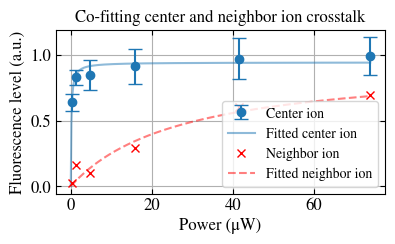

a_center_fitted: 0.14622995992504004, b_fitted: 4713.594051721343, c_center_fitted: 24.989728061861147
a_side_fitted: 27.679356509500764, c_side_fitted: 1e-10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib

# Updating matplotlib parameters for better plot aesthetics
matplotlib.rcParams.update({
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "xtick.direction": "in",
    "xtick.major.pad": 3,
    "xtick.top": True,
    "ytick.labelsize": 12,
    "ytick.direction": "in",
    "ytick.right": True,
    "axes.labelsize": 12,
    "axes.labelpad": 3,
    "axes.grid": True
})

# Arrays of power and counts for center and side measurements
power = np.array([0.283, 1.27, 4.67, 15.8, 41.5, 74.0])
counts_center = np.array([3187.25, 4139.625, 4236.6875, 4562.6875, 4859.1875, 4940.8125])
counts_side = np.array([117, 815, 506, 1448.5, 3023, 3479])
std_counts_center = np.array([340.90, 275.00, 578.03, 675.35, 775.13, 722.43])

# Define the fitting function
def fit_function(power, a, b, c):
    return (b * power) / (a + power)# + c

# Define combined fitting function to use shared parameter 'b' for both datasets
def combined_fit_function(power, a_center, b, c_center, a_side, c_side):
    # Separate power for center and side based on input length
    num_points = len(power) // 2
    return np.concatenate([
        fit_function(power[:num_points], a_center, b, c_center),
        fit_function(power[num_points:], a_side, b, c_side)
    ])

# Combine data for fitting
combined_power = np.concatenate([power, power])
combined_counts = np.concatenate([counts_center, counts_side])
combined_errors = np.concatenate([std_counts_center, np.zeros_like(counts_side)])  # No error for side counts

# Initial guesses: Choose values that are physically meaningful and avoid problematic operations
initial_guess = [1, 100, 0, 1, 0]  # Adjust these based on your knowledge of the system

# Perform the curve fitting with revised initial guesses and check for errors
try:
    params, params_covariance = curve_fit(combined_fit_function, combined_power, combined_counts, p0=initial_guess, bounds=(0, np.inf))
    print("Fitting succeeded.")
except Exception as e:
    print(f"Fitting failed: {str(e)}")

# Extract fitted parameters
a_center_fitted, b_fitted, c_center_fitted, a_side_fitted, c_side_fitted = params

# Generate a smooth range of power values for plotting the fitted curves
power_smooth = np.linspace(0, power.max(), 500)

# Calculate fitted curves
fitted_curve_center = fit_function(power_smooth, a_center_fitted, b_fitted, c_center_fitted)
fitted_curve_side = fit_function(power_smooth, a_side_fitted, b_fitted, c_side_fitted)

# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
# Plotting with "I" shaped error bars
# Plotting with differentiated color intensities
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))

# Fitting line - dim color
plt.plot(power_smooth, fitted_curve_center / 5000, label='Fitted center ion', color='C0', alpha=0.5)  # Reduced opacity for the fitting line
# Real data with error bars - darker color
plt.errorbar(power, counts_center / 5000, yerr=std_counts_center / 5000, fmt='o', color='C0', ecolor='C0', capsize=5, label='Center ion')

plt.plot(power, counts_side / 5000, 'x', label='Neighbor ion', color='red')
plt.plot(power_smooth, fitted_curve_side / 5000, '--', label='Fitted neighbor ion', color='red', alpha=0.5)  # Apply similar styling for consistency

plt.xlabel("Power (μW)", fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Fluorescence level (a.u.)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.title('Co-fitting center and neighbor ion crosstalk', fontdict={'family': 'STIXGeneral', 'size': 12})
# After all plotting commands
handles, labels = plt.gca().get_legend_handles_labels()

# Customize the order here. For example, to bring 'Neighbor ion' and its fitted curve first, you could do something like:
# Assuming 'Neighbor ion' and 'Fitted neighbor ion' are the last two labels in your current setup,
# and you want them to be first in the legend:
ordered_labels = ['Center ion', 'Fitted center ion', 'Neighbor ion', 'Fitted neighbor ion']
ordered_handles = [handles[labels.index(lbl)] for lbl in ordered_labels]

# Use in plt.legend()
plt.legend(ordered_handles, ordered_labels)

plt.grid(True)
# Rest of your plotting and saving code follows
pdf_filename = 'Crosstalk_fitting.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# Print fitted parameters for review
print(f"a_center_fitted: {a_center_fitted}, b_fitted: {b_fitted}, c_center_fitted: {c_center_fitted}")
print(f"a_side_fitted: {a_side_fitted}, c_side_fitted: {c_side_fitted}")

In [4]:
import numpy as np

# Data
data = {
    'p0988': [222, 260, 13, 306, 301],
    'p0998': [1160, 824, 837, 1083],
    'p1003': [1614, 1757, 1887],
    'p1008': [1884, 2881, 2267],
    'p1013': [1775, 1981, 1832, 2023, 2569],
    'p1018': [2628, 2318, 1394, 2276],
    'p1023': [3122, 3513, 2894, 3862],
    'p1028': [2818, 2545, 2830, 1857],
    'p1033': [1874, 492, 871, 919, 873, 569],
    'p1038': [3, 240, 132, 1],
    'p1048': [0, 0, 0, 6, 92, 70],
}

data = {
    'p0988': [222, 260, 306, 301],
    'p0998': [1160, 824, 837, 1083],
    'p1003': [1614, 1757, 1887],
    'p1008': [1884, 2267],
    'p1013': [1775, 1981, 1832, 2023, 2569],
    'p1018': [2628, 2318, 2276],
    'p1023': [3122, 3513, 2894, 3862],
    'p1028': [2818, 2545, 2830],
    'p1033': [492, 871, 919, 873, 569],
    'p1038': [240, 132],
    'p1048': [92, 70],
}

# Calculate averages and standard deviations
averages = []
std_devs = []

for key, values in data.items():
    avg = np.mean(values)
    std_dev = np.std(values, ddof=1)  # Using ddof=1 for sample standard deviation
    averages.append(avg)
    std_devs.append(std_dev)

# X-axis values

averages, std_devs

([272.25,
  976.0,
  1752.6666666666667,
  2075.5,
  2036.0,
  2407.3333333333335,
  3347.75,
  2731.0,
  744.8,
  186.0,
  81.0],
 [39.33086150425219,
  171.00682247598584,
  136.55157755710235,
  270.82189719444773,
  315.04761544883974,
  192.25330512980352,
  427.63409203040237,
  161.19243158411626,
  198.44445066567116,
  76.36753236814714,
  15.556349186104045])

Fitted parameters: a = 2851.73, b = 9.107, c = 3.749, d = 0.00


/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_74819/2155539734.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_values, counts, p0=[max(counts), np.mean(x_values), np.std(x_values), 0])


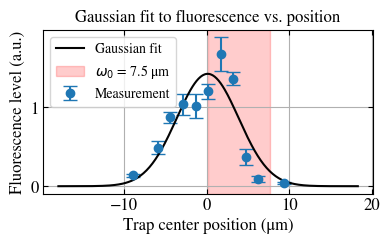

Beam waist (w_0): 7.498 units


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib

# Updating matplotlib parameters for better plot aesthetics
matplotlib.rcParams.update({
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "xtick.direction": "in",
    "xtick.major.pad": 3,
    "xtick.top": True,
    "ytick.labelsize": 12,
    "ytick.direction": "in",
    "ytick.right": True,
    "axes.labelsize": 12,
    "axes.labelpad": 3,
    "axes.grid": True
})

# Data
x_values = [0.988, 0.998, 1.003, 1.008, 1.013, 1.018, 1.023, 1.028, 1.033, 1.038, 1.048]
# x_values = [0.988, 0.998, 1.003, 1.008, 1.013, 1.018, 1.028, 1.033, 1.038, 1.048]
x_values = (np.array((x_values)) - 0.988) * 305.159
counts = np.array(averages)
std_devs = np.array(std_devs)

# Gaussian function
def gaussian(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2))# + d

# Perform the curve fitting
popt, pcov = curve_fit(gaussian, x_values, counts, p0=[max(counts), np.mean(x_values), np.std(x_values), 0])

# Print fitted parameters
print(f"Fitted parameters: a = {popt[0]:.2f}, b = {popt[1]:.3f}, c = {popt[2]:.3f}, d = {popt[3]:.2f}")

w_0 = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # popt[2] is 'c', the standard deviation

# Fitted parameter for standard deviation 'c'
sigma = popt[2]

# Calculating the beam waist w_0
# w_0 = 2 * np.sqrt(2 * np.log(2)) * sigma

w_0 = 2 * sigma

# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio

# Plotting with differentiated color intensities
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.errorbar(x_values - 9, counts / 2000, yerr=std_devs / 2000, fmt='o', capsize=5, label='Measurement')
x_fit = np.linspace(min(x_values) - 9, max(x_values) + 9, 300)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit - 9, y_fit / 2000, 'black', label='Gaussian fit', alpha=0.99)
beam_waist_location =  popt[1] + w_0 / 2
# plt.axvspan(beam_waist_location - w_0/2, beam_waist_location + w_0/2, alpha=0.2, color='green', label=f'Beam waist ($\omega_0$) = {w_0:.1f} $\mu m$')
plt.axvspan(beam_waist_location - w_0/2 - 9, beam_waist_location + w_0/2 - 9, alpha=0.2, color='red', label=f'$\omega_0$ = {w_0:.1f} μm')

plt.xlabel('Trap center position (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Fluorescence level (a.u.)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.title('Gaussian fit to fluorescence vs. position', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.legend()
# plt.legend(loc='best')
plt.legend(loc='upper left')
plt.grid(True)
pdf_filename = 'Beam_waist.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

print(f"Beam waist (w_0): {w_0:.3f} units")

In [18]:
gaussian(8.38512928 + 9.107, *popt) / gaussian(0 + 9.107, *popt)
gaussian(11.05598552 + 9.107, a=2851.73, b=9.107, c=3.749, d=0) / gaussian(0 + 9.107, a=2851.73, b=9.107, c=3.749, d=0)

0.012926889930110536

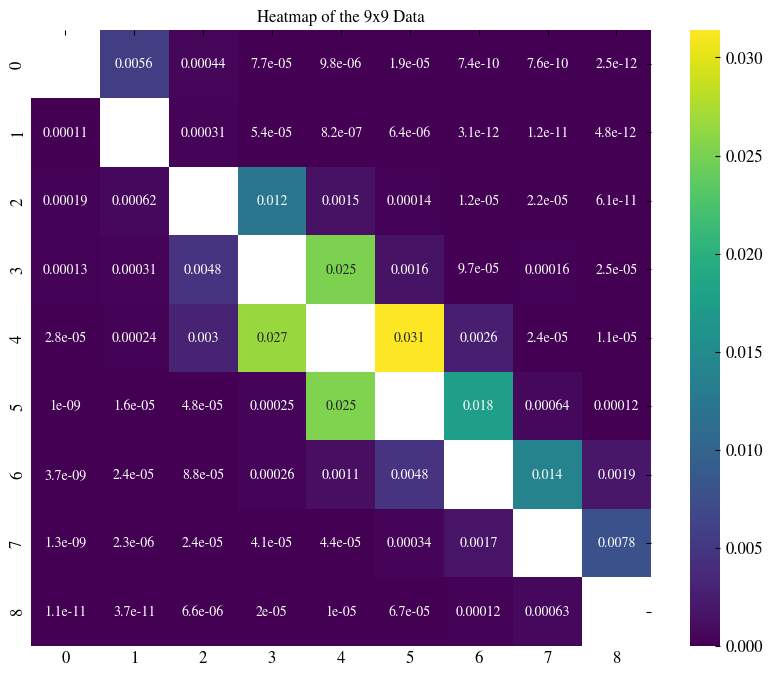

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Given data as a list of lists (each sublist is a row in the array)
data = [
    [np.nan, 0.0056116, 0.00044006, 7.66287E-05, 9.84778E-06, 1.87251E-05, 7.36E-10, 7.58E-10, 2.5E-12],
    [1.06E-04, np.nan, 0.000308761, 5.38E-05, 8.23E-07, 6.41E-06, 3.06E-12, 1.23E-11, 4.79E-12],
    [0.000193324, 0.000621632, np.nan, 0.012357653, 0.001459536, 0.000143806, 1.18E-05, 2.17E-05, 6.10E-11],
    [1.29E-04, 0.000307855, 0.004782259, np.nan, 0.02525301, 0.001553243, 9.69E-05, 1.65E-04, 2.50E-05],
    [2.79683E-05, 0.000243662, 0.003039265, 0.026578051, np.nan, 0.031408885, 0.002617777, 2.41421E-05, 1.0962E-05],
    [1.04E-09, 1.57E-05, 4.78628E-05, 0.000250941, 0.025315461, np.nan, 0.017510249, 0.000638342, 0.000115305],
    [3.69E-09, 2.37E-05, 8.77E-05, 0.000264499, 0.00114817, 0.004771396, np.nan, 0.01409818, 0.001886434],
    [1.26E-09, 2.31E-06, 2.38E-05, 4.06E-05, 4.45E-05, 0.000343956, 0.001669408, np.nan, 0.00780513],
    [1.1E-11, 3.67E-11, 6.65E-06, 1.98E-05, 1.03E-05, 6.70E-05, 0.00012471, 0.000627771, np.nan]
]

# Convert the data into a 2D numpy array
array_2d = np.array(data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(array_2d, annot=True, fmt=".2g", cmap='viridis')
plt.title('Heatmap of the 9x9 Data')
plt.show()

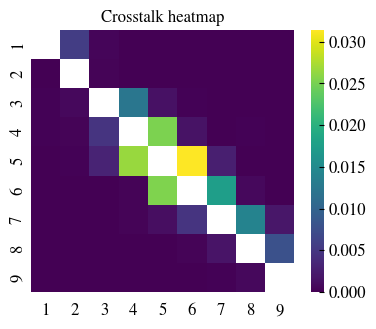

In [ ]:
import matplotlib
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 8,
         "xtick.top": False,
         "xtick.bottom": False,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": False,
         "ytick.left": False,
         "axes.labelsize": 12,
         "axes.labelpad": 10,
         "axes.grid": False
    }
)

# Mask the main diagonal by setting it to NaN so it is not considered in plotting
masked_array = np.array(array_2d)
np.fill_diagonal(masked_array, np.nan)

# Plot the heatmap with the main diagonal masked
half_column_width_inches = 4.25
aspect_ratio = 1.25  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.figure(figsize=(10, 8))
sns.heatmap(masked_array, annot=False, fmt=".2g", cmap='viridis', mask=np.isnan(masked_array))
tick_labels = np.arange(1, 10)  # Generates labels from 1 to 9
plt.xticks(ticks=np.arange(0.5, len(masked_array)+0.5), labels=tick_labels, fontdict={'family': 'STIXGeneral', 'size': 12})  # Set x-axis labels
plt.yticks(ticks=np.arange(0.5, len(masked_array)+0.5), labels=tick_labels, fontdict={'family': 'STIXGeneral', 'size': 12})  # Set y-axis labels
plt.title('Crosstalk heatmap', fontdict={'family': 'STIXGeneral', 'size': 12})
# Save the figure with tight bounding box
pdf_filename = 'Crosstalk.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

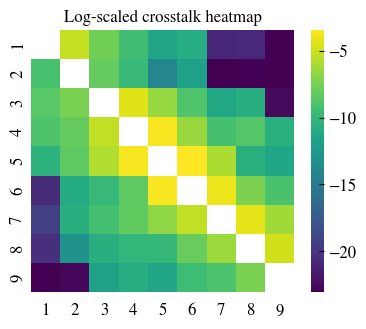

In [ ]:
import matplotlib
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 8,
         "xtick.top": False,
         "xtick.bottom": False,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": False,
         "ytick.left": False,
         "axes.labelsize": 12,
         "axes.labelpad": 10,
         "axes.grid": False
    }
)

# Convert the data into a 2D numpy array
array_2d = np.array([
    [1, 0.0056116, 0.00044006, 7.66287E-05, 9.84778E-06, 1.87251E-05, 7.36E-10, 7.58E-10, 0],
    [1.06E-04, 1, 0.000308761, 5.38E-05, 8.23E-07, 6.41E-06, 3.06E-12, 1.23E-11, 4.79E-12],
    [0.000193324, 0.000621632, 1, 0.012357653, 0.001459536, 0.000143806, 1.18E-05, 2.17E-05, 6.10E-11],
    [1.29E-04, 0.000307855, 0.004782259, 1, 0.02525301, 0.001553243, 9.69E-05, 1.65E-04, 2.50E-05],
    [2.79683E-05, 0.000243662, 0.003039265, 0.026578051, 1, 0.031408885, 0.002617777, 2.41421E-05, 1.0962E-05],
    [1.04E-09, 1.57E-05, 4.78628E-05, 0.000250941, 0.025315461, 1, 0.017510249, 0.000638342, 0.000115305],
    [3.69E-09, 2.37E-05, 8.77E-05, 0.000264499, 0.00114817, 0.004771396, 1, 0.01409818, 0.001886434],
    [1.26E-09, 2.31E-06, 2.38E-05, 4.06E-05, 4.45E-05, 0.000343956, 0.001669408, 1, 0.00780513],
    [0, 3.67E-11, 6.65E-06, 1.98E-05, 1.03E-05, 6.70E-05, 0.00012471, 0.000627771, 1]
])

# Apply log scale, adding a small constant to avoid log(0)
log_scale_data = np.log(array_2d + 1e-10)

# Mask the main diagonal to not display the '1' values in the heatmap
mask = np.eye(log_scale_data.shape[0], dtype = bool)

# Plot the heatmap
# Plot the heatmap with the main diagonal masked
half_column_width_inches = 4.25
aspect_ratio = 1.25  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
sns.heatmap(log_scale_data, mask=mask, annot=False, fmt=".2g", cmap='viridis')
tick_labels = np.arange(1, 10)  # Generates labels from 1 to 9
plt.xticks(ticks=np.arange(0.5, len(masked_array)+0.5), labels=tick_labels)  # Set x-axis labels
plt.yticks(ticks=np.arange(0.5, len(masked_array)+0.5), labels=tick_labels)  # Set y-axis labels
plt.title('Log-scaled crosstalk heatmap')
# plt.xlabel('Ion Number')
# plt.ylabel('Ion Number')
# Save the figure with tight bounding box
pdf_filename = 'Crosstalk_Log-scaled.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

In [3]:
import numpy as np

data = [
    [np.nan, 0.0056116, 0.00044006, 7.66287E-05, 9.84778E-06, 1.87251E-05, 7.36E-10, 7.58E-10, 2.5E-12],
    [1.06E-04, np.nan, 0.000308761, 5.38E-05, 8.23E-07, 6.41E-06, 3.06E-12, 1.23E-11, 4.79E-12],
    [0.000193324, 0.000621632, np.nan, 0.012357653, 0.001459536, 0.000143806, 1.18E-05, 2.17E-05, 6.10E-11],
    [1.29E-04, 0.000307855, 0.004782259, np.nan, 0.02525301, 0.001553243, 9.69E-05, 1.65E-04, 2.50E-05],
    [2.79683E-05, 0.000243662, 0.003039265, 0.026578051, np.nan, 0.031408885, 0.002617777, 2.41421E-05, 1.0962E-05],
    [1.04E-09, 1.57E-05, 4.78628E-05, 0.000250941, 0.025315461, np.nan, 0.017510249, 0.000638342, 0.000115305],
    [3.69E-09, 2.37E-05, 8.77E-05, 0.000264499, 0.00114817, 0.004771396, np.nan, 0.01409818, 0.001886434],
    [1.26E-09, 2.31E-06, 2.38E-05, 4.06E-05, 4.45E-05, 0.000343956, 0.001669408, np.nan, 0.00780513],
    [1.1E-11, 3.67E-11, 6.65E-06, 1.98E-05, 1.03E-05, 6.70E-05, 0.00012471, 0.000627771, np.nan]
]

# Data
data = {
    '1': [0.000627771, 1.06E-04],
    '2': [0.000621632, 0.001669408],
    '3': [0.004782259, 0.004771396],
    '4': [0.026578051, 0.025315461],
    '5': [0.031408885, 0.02525301],
    '6': [0.012357653, 0.017510249],
    '7': [0.000308761, 0.01409818],
    '8': [0.0056116, 0.00780513],
}

# Calculate averages and standard deviations
averages = []
std_devs = []

for key, values in data.items():
    avg = np.mean(values)
    std_dev = np.std(values, ddof=1)  # Using ddof=1 for sample standard deviation
    averages.append(avg)
    std_devs.append(std_dev)

# X-axis values

averages, std_devs

([0.00036688549999999996,
  0.0011455200000000001,
  0.0047768275,
  0.025946756,
  0.0283309475,
  0.014933950999999999,
  0.0072034705,
  0.006708365],
 [0.00036894781232648603,
  0.0007408895147645161,
  7.681300964029357e-06,
  0.0008927859508583212,
  0.004352860956636737,
  0.003643435572314679,
  0.00975059168352262,
  0.0015510599377361281])

Fitted parameters: a = 0.03, b = 0.195, c = 3.006, d = 0.00


/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_70141/3918880217.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_values, counts, p0=[max(counts), 0, 5, 0])


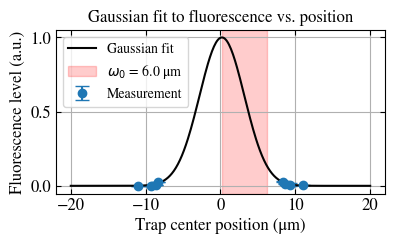

Beam waist (w_0): 6.013 units


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib

# Updating matplotlib parameters for better plot aesthetics
matplotlib.rcParams.update({
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "xtick.direction": "in",
    "xtick.major.pad": 3,
    "xtick.top": True,
    "ytick.labelsize": 12,
    "ytick.direction": "in",
    "ytick.right": True,
    "axes.labelsize": 12,
    "axes.labelpad": 3,
    "axes.grid": True
})

# Data
x_values = [-11.05598552, -9.37316988, -8.66916473, -8.38512928, 8.38512928, 8.66916473, 9.37316988, 11.05598552]
x_values = (np.array((x_values)))
counts = np.array(averages)
std_devs = np.array(std_devs)

# Gaussian function
def gaussian(x, a, b, c, d):
    return np.exp(-(x - b)**2 / (2 * c**2))# + d

# Perform the curve fitting
popt, pcov = curve_fit(gaussian, x_values, counts, p0=[max(counts), 0, 5, 0])

# Print fitted parameters
print(f"Fitted parameters: a = {popt[0]:.2f}, b = {popt[1]:.3f}, c = {popt[2]:.3f}, d = {popt[3]:.2f}")

w_0 = 2 * np.sqrt(2 * np.log(2)) * popt[2]  # popt[2] is 'c', the standard deviation

# Fitted parameter for standard deviation 'c'
sigma = popt[2]

# Calculating the beam waist w_0
# w_0 = 2 * np.sqrt(2 * np.log(2)) * sigma

w_0 = 2 * sigma

# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio

# Plotting with differentiated color intensities
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.errorbar(x_values, counts, yerr=std_devs, fmt='o', capsize=5, label='Measurement')
x_fit = np.linspace(min(x_values) - 9, max(x_values) + 9, 300)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, 'black', label='Gaussian fit', alpha=0.99)
beam_waist_location =  popt[1] + w_0 / 2
# plt.axvspan(beam_waist_location - w_0/2, beam_waist_location + w_0/2, alpha=0.2, color='green', label=f'Beam waist ($\omega_0$) = {w_0:.1f} $\mu m$')
plt.axvspan(beam_waist_location - w_0/2, beam_waist_location + w_0/2, alpha=0.2, color='red', label=f'$\omega_0$ = {w_0:.1f} μm')

plt.xlabel('Trap center position (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Fluorescence level (a.u.)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.title('Gaussian fit to fluorescence vs. position', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.legend()
# plt.legend(loc='best')
plt.legend(loc='upper left')
plt.grid(True)
pdf_filename = 'Beam_waist.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

print(f"Beam waist (w_0): {w_0:.3f} units")